# Klasyfikacja obiektów kosmicznych - Modelowanie - *Walidacja*

*Wszelkie uwagi i dopiski zespołu walidacji dodane zostały do wyjściowego pliku kursywą.*

*Zespół walidacji wywołał cały kod dla danych developerskich (development_unit - dzielony na tym etapie na training_sample i validation_sample), żeby sprawdzić jego poprawność. Wywołanie przebiegło poprawnie.*

*Fragmenty kodu związane z działaniami na danych treningowych, w tym trenowanie modeli, nie będą szerzej komentowane. Na tym etapie zespół walidacji skupił się głównie na wynikach wytrenowanych modeli, nie ingerował w sam proces treningu.*

*Walidacja będzie przeprowadzona na zbiorze danych walidacyjnych (validation_unit - wydzielonych przez grupę developerską na początku projektu) poprzez wywołanie na ww. zbiorze tych fragmentów kodu, które zespół developerski wywoływał na próbce validation_sample (w kodzie z dopiskiem 'test' w nazwach).* 

#### 0. Dane 
#### 0.1. Pakiety


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# scaling
from sklearn.preprocessing import MinMaxScaler

# random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# svm
from sklearn.svm import SVC

# decision tree
from sklearn.tree import DecisionTreeClassifier

# logistic regression
from sklearn.linear_model import LogisticRegression

# naive bayes gaussianNB
from sklearn.naive_bayes import GaussianNB

# knn
from sklearn.neighbors import KNeighborsClassifier

# adaboost
from sklearn.ensemble import AdaBoostClassifier

# svc
from sklearn.svm import SVC

# xgboost
from xgboost import XGBClassifier

# stacking
from sklearn.ensemble import StackingClassifier

# crossvalidation & hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

import warnings
from sklearn.exceptions import FitFailedWarning
# Filter out the FitFailedWarning
warnings.filterwarnings("ignore", category=FitFailedWarning)

# encoding for xg boost
from sklearn.preprocessing import LabelEncoder

from tabulate import tabulate

# roc curve
from sklearn.metrics import roc_curve, auc

# shap
import shap
shap.initjs()


#### 0.2. Podział na zbiór treningowy i testowy

*Wczytujemy zbiory danych: walidacyjny i deweloperski. Ze zbioru danych deweloperskich skorzystamy tylko z części treningowej, natomiast dane testowe zespołu budowy zastąpimy danymi walidacyjnymi.*

In [3]:
# wczytanie danych
df = pd.read_csv('development_data.csv')
valid_df = pd.read_csv('validation_data.csv')

# podział danych na zbiór treningowy i testowy
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

# reset indeksów
train_df = train_df.reset_index(drop=True)
# test_df = test_df.reset_index(drop=True)

# kolumny z waznymi cechami
imp_cols = ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'spec_obj_ID', 'redshift']

# X - ramka danych ograniczona do interesujących nas cech
X = train_df[imp_cols]
y = train_df['class'].values

# X_test = test_df[imp_cols]
# y_test = test_df['class'].values

X_valid = valid_df[imp_cols]
y_valid = valid_df['class'].values

### 0.3. Normalizacja

In [4]:
scaling = MinMaxScaler()
X = scaling.fit_transform(X)
X_valid = scaling.transform(X_valid)

X = pd.DataFrame(X, columns=imp_cols)
X_valid = pd.DataFrame(X_valid, columns=imp_cols)

## 1. Feature importance 
 Feature importance raz jeszcze.
- Wykorzystamy Gini, oprócz Random Forest Classifier.  
- Nowopowstałe zmienne będące funkcjami redshift miały tak duże znaczenie, które było zwiększane przede wszystkim przez zmienną redshift. W związku z czym, nie wnosiły one nowych informacji do modelu, jedynie stanowiły słabe powielenie cechy redshift.  
- Wszelkie próby stworzenia cech niemających uzasadnienia fizycznego, np. modyfikacje redshift, alfa oraz delta, nie ulepszały naszego modelu.
- Wszystkie cechy mają niezerową wariancję (var > 0.0001).

*Powyższe wnioski uwzględniają uwagi Prowadzącego dotyczące etapu Feature importance & Feature selection. Obserwacje dotyczące dużego wpływu nowopowstałych zmiennych wydają się być poprawne.*

In [5]:
# copy X for testing purposes
X_ = X.copy()

# add new features
X_['u-g'] = X_['u'] - X_['g']
X_['g-r'] = X_['g'] - X_['r']
X_['r-i'] = X_['r'] - X_['i']
X_['i-z'] = X_['i'] - X_['z']
X_['u-r'] = X_['u'] - X_['r']
X_['ug_mr'] = np.log(X_['u'] / X_['g'])
X_['ri_mr'] = np.log(X_['r'] / X_['i'])
X_['iz_mr'] = np.log(X_['i'] / X_['z'])

# add new features to the list of important columns
imp_cols_ = imp_cols + ['u-g', 'g-r', 'r-i', 'i-z', 'u-r', 'ug_mr', 'ri_mr', 'iz_mr']

# change NaNs to median value --- there is only one NaN in each column
median_ug_mr = X_['ug_mr'].median()
X_['ug_mr'] = X_['ug_mr'].fillna(median_ug_mr)

median_r_i = X_['ri_mr'].median()
X_['ri_mr'] = X_['ri_mr'].fillna(median_r_i)

median_iz_mr = X_['iz_mr'].median()
X_['iz_mr'] = X_['iz_mr'].fillna(median_iz_mr)


In [6]:
# define function to generate featrue importance plot
def plot_feature_importance(model, X, imp_cols):

    feature_importance = model.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    # Print feature ranking and name the features
    print("Feature ranking:")
    for f in range(X.shape[1]):
        print(f"{f + 1}. Feature {imp_cols[indices[f]]} ({feature_importances[indices[f]]})")  
    
    # Plot the feature importances of the forest
    plt.figure(figsize=(10, 10))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, np.array(imp_cols)[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()

### 1.1. Random Forest Classifier

Feature ranking:
1. Feature redshift (0.4495571735359382)
2. Feature ri_mr (0.13254258574318298)
3. Feature g-r (0.09701784848937481)
4. Feature iz_mr (0.06983282992470993)
5. Feature u-r (0.06720007558823553)
6. Feature i-z (0.04365867905747776)
7. Feature r-i (0.03311546431753257)
8. Feature u-g (0.022163698093565044)
9. Feature z (0.020094197527958504)
10. Feature i (0.017405204411224794)
11. Feature g (0.014195708668332562)
12. Feature spec_obj_ID (0.01055534564942468)
13. Feature r (0.009173593565830453)
14. Feature ug_mr (0.00828725982564021)
15. Feature u (0.004464725217635982)
16. Feature alpha (0.0004875481243563388)
17. Feature delta (0.00024806225957977023)


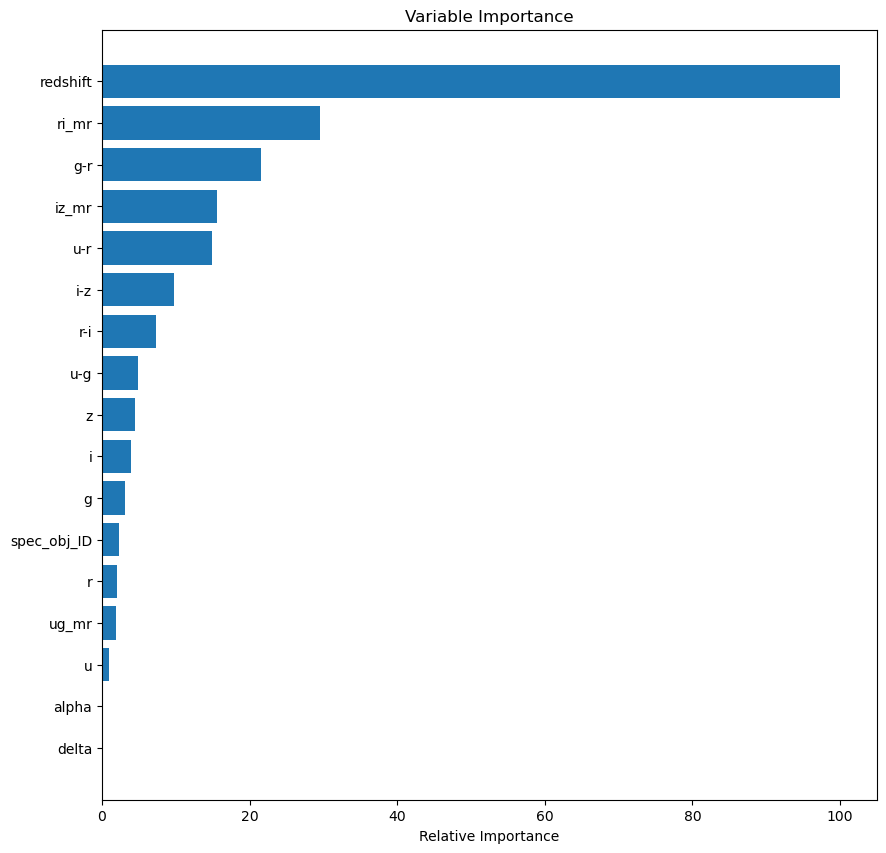

In [7]:
# train random forest classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
clf.fit(X_, y)

# get feature importances from the model
feature_importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(feature_importances)[::-1]

plot_feature_importance(clf, X_, imp_cols_)

### 1.2. Gini

Feature ranking:
1. Feature redshift (0.8612806124630425)
2. Feature g-r (0.04893648780797637)
3. Feature r (0.015958441650050573)
4. Feature g (0.014996635345875975)
5. Feature spec_obj_ID (0.008162720433064236)
6. Feature ri_mr (0.005931104858314397)
7. Feature r-i (0.005594791796970766)
8. Feature delta (0.005273723088081056)
9. Feature alpha (0.0051520999143190695)
10. Feature u-r (0.005054991177883805)
11. Feature ug_mr (0.004087356543786321)
12. Feature i-z (0.004061979839340624)
13. Feature z (0.003359090744403863)
14. Feature iz_mr (0.0031881962821319475)
15. Feature u (0.0031816498822822325)
16. Feature i (0.0029445116251987737)
17. Feature u-g (0.002835606547277209)


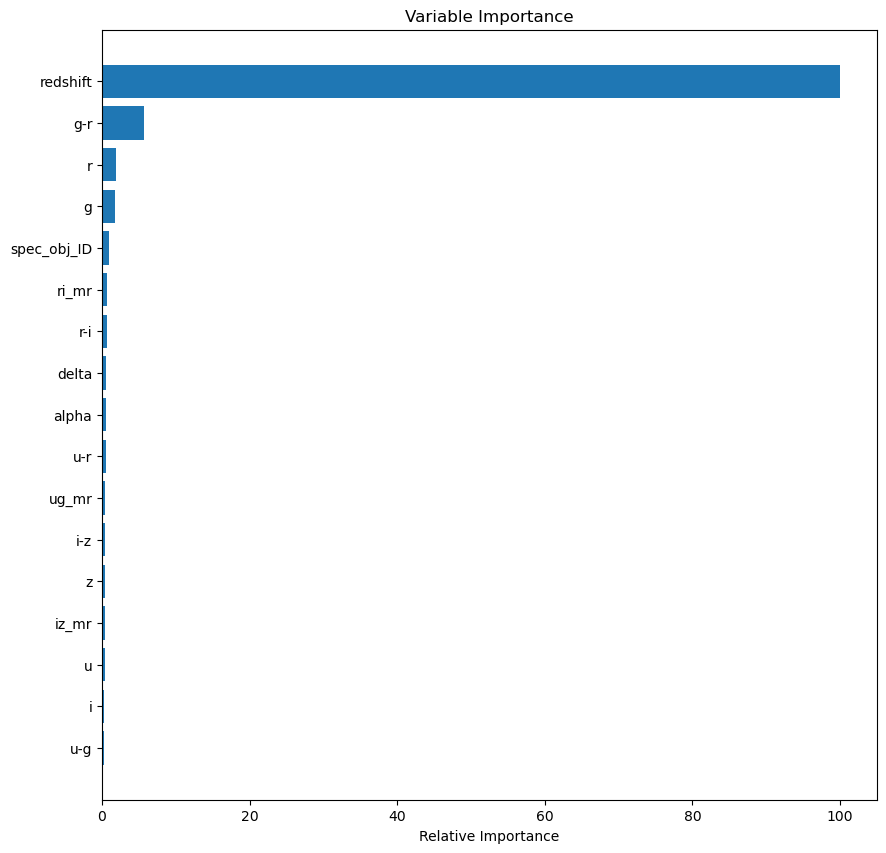

In [13]:
# train gini
clf = DecisionTreeClassifier(criterion='gini', random_state=42)
clf.fit(X_, y)

# get feature importances from the model
feature_importances = clf.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plot_feature_importance(clf, X_, imp_cols_)

Według modelu Gini, cechami posiadającymi współczynnik ważności >= 5% są:
- redshift,
- g-r.  

A co jeśli nie będzie redshift?

*Rzeczywiście, zmienna redshift ma wyraźnie większy wpływ na model niż pozostałe. Ciekawy pomysł ze sprawdzeniem, jak zachowają się modele bez tej cechy.*

### 1.2.1. Gini, ale bez zmiennej redshift CZY TO MA SENS???

Feature ranking:
1. Feature ri_mr (0.37314685307628903)
2. Feature u-r (0.12662976434195208)
3. Feature spec_obj_ID (0.09180271546275612)
4. Feature g-r (0.0697556382795857)
5. Feature iz_mr (0.041596782934339535)
6. Feature i (0.0411664753459561)
7. Feature r-i (0.0334788506378608)
8. Feature g (0.03318187558710901)
9. Feature u-g (0.03239837159215786)
10. Feature alpha (0.02713154341322022)
11. Feature delta (0.02624258901405764)
12. Feature z (0.025532076175611138)
13. Feature ug_mr (0.02349336769043515)
14. Feature i-z (0.023359640875128554)
15. Feature u (0.01811105085187495)
16. Feature r (0.012972404721666076)


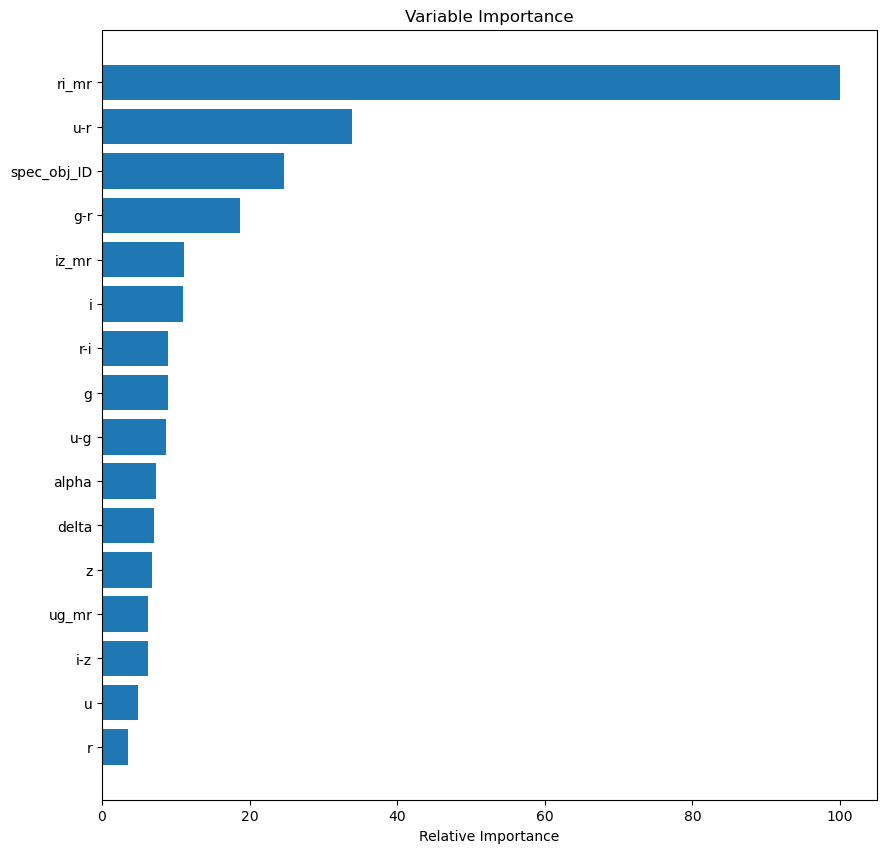

In [14]:
# for testing purposes remove redshift from X_
X_no_redshift = X_.drop(columns=['redshift'])
imp_cols_no_redshift = imp_cols_.copy()
imp_cols_no_redshift.remove('redshift')

# train gini
clf = DecisionTreeClassifier(criterion='gini', random_state=42)
clf.fit(X_no_redshift, y)

# get feature importances from the model
feature_importances = clf.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plot_feature_importance(clf, X_no_redshift, imp_cols_no_redshift)

Teraz, zmienne:
- ri_mr (poprzednio bardzo nisko),
- u-r,
- spec_obj_ID,
- g-r

mają współczynniki Gini >= 5%.

*Ciekawe, że bez zmiennej redshift inne cechy, które wcześniej miały bardzo niewielki wpływ na modele - chociażby wspomniane wyżej ri_mr - mają znacząco wyższe wyniki niż pozostałe, które poprzednio plasowały się wyżej.*

### 1.3. Tylko cechy podstawowe


Random Forest
Feature ranking:
1. Feature redshift (0.6645266697666725)
2. Feature z (0.09700775427299273)
3. Feature g (0.06262542492272952)
4. Feature i (0.062055616537353635)
5. Feature u (0.05567218816556349)
6. Feature spec_obj_ID (0.03446543552736725)
7. Feature r (0.021729454403647395)
8. Feature delta (0.0011434600187883348)
9. Feature alpha (0.0007739963848850892)


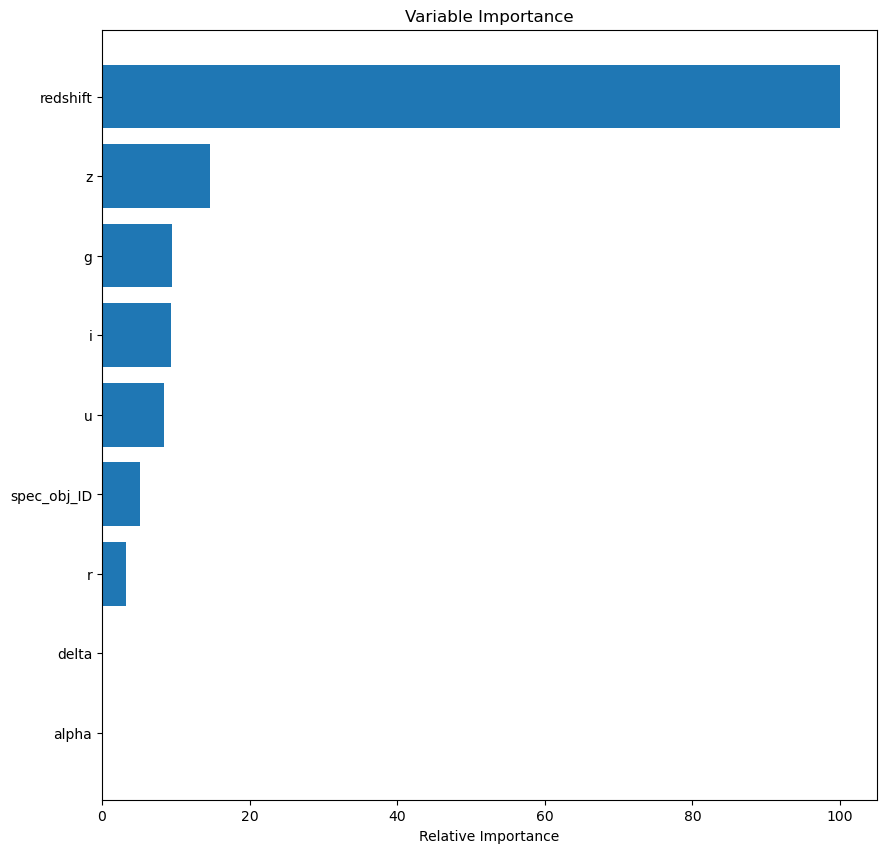

Gini Decision Tree
Feature ranking:
1. Feature redshift (0.8655909945368427)
2. Feature g (0.0537037419514874)
3. Feature u (0.02544293892291465)
4. Feature z (0.011691287518352961)
5. Feature i (0.010718054483345714)
6. Feature spec_obj_ID (0.009915345905802907)
7. Feature r (0.008653893749507268)
8. Feature alpha (0.007479638692331413)
9. Feature delta (0.006804104239414936)


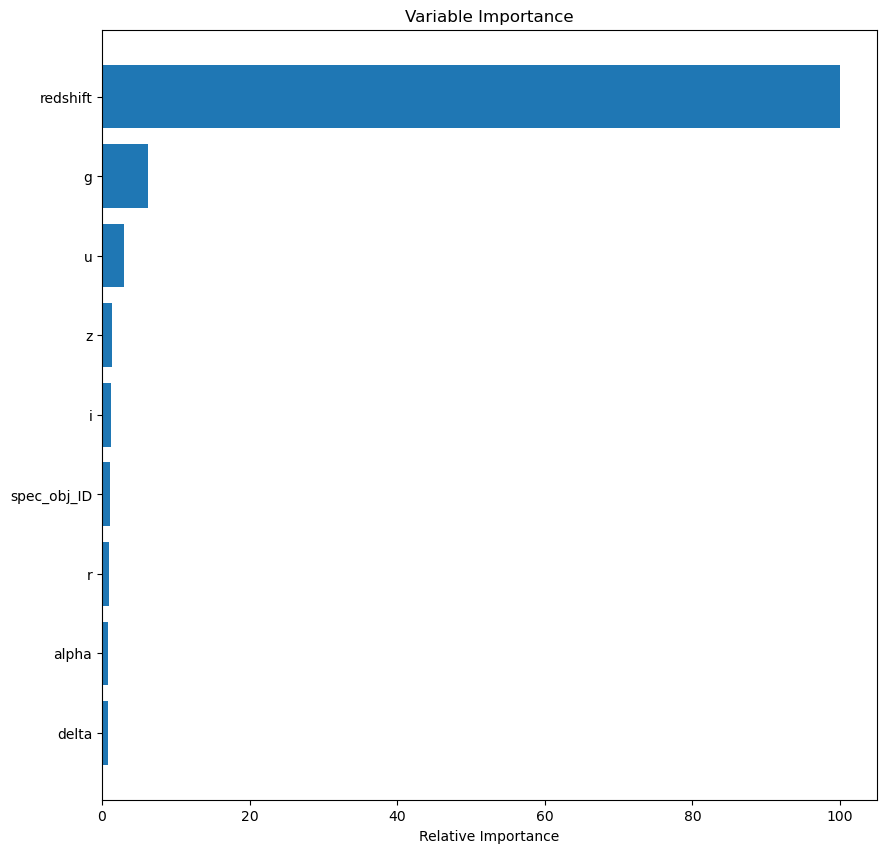

In [15]:
# train random forest classifier
print("Random Forest")
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
clf.fit(X, y)

# get feature importances from the model
feature_importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(feature_importances)[::-1]

plot_feature_importance(clf, X, imp_cols)

# train gini
print("Gini Decision Tree")
clf = DecisionTreeClassifier(criterion='gini', random_state=42)
clf.fit(X, y)

# get feature importances from the model
feature_importances = clf.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plot_feature_importance(clf, X, imp_cols)

### 1.4. Wybór cech do modelu

Według **random forest classifier** najmniej istotnymi cechami były:
- u-g 
- z 
- i 
- g 
- spec_obj_ID 
- r 
- ug_mr 
- u 
- alpha 
- delta 

Według **gini (decision tree)** najmniej istotnymi cechami były:
- r
- r-i 
- alpha 
- ri_mr 
- delta 
- u-r 
- i-z 
- u-g 
- z 
- iz_mr 
- ug_mr 
- i 
- u 

Zatem w modelu nie będziemy uwzględniać:
- u
- alpha (choć mapa nieba inaczej sugerowała)
- delta (choć mapa nieba inaczej sugerowała)
- r (pomimo 3. pozycji w Gini (0.02 pkt))
- ug_mr
- u-g

Usuwamy powyższe z imp_cols_. Zachowamy ramki danych treningową i testową bez nowych cech pod zmiennymi X_org i X_test_org. Do ramek X i X_test dodajemy nowe cechy.

In [17]:
# let X_org be the original X and X_test_org be the original X_test
X_org = X.copy()
# X_test_org = X_test.copy()
X_valid_org = X_valid.copy()

# let X be the X_ with removed columns
X = X_.drop(columns=['u', 'alpha', 'delta', 'r', 'ug_mr', 'u-g'])


# add 'g-r', 'r-i', 'i-z', 'u-r', 'ri_mr', 'iz_mr' to X_test 
# X_test['g-r'] = X_test['g'] - X_test['r']
# X_test['r-i'] = X_test['r'] - X_test['i']
# X_test['i-z'] = X_test['i'] - X_test['z']
# X_test['u-r'] = X_test['u'] - X_test['r']
# X_test['ri_mr'] = np.log(X_test['r'] / X_test['i'])
# X_test['iz_mr'] = np.log(X_test['i'] / X_test['z'])

# add 'g-r', 'r-i', 'i-z', 'u-r', 'ri_mr', 'iz_mr' to X_valid
X_valid['g-r'] = X_valid['g'] - X_valid['r']
X_valid['r-i'] = X_valid['r'] - X_valid['i']
X_valid['i-z'] = X_valid['i'] - X_valid['z']
X_valid['u-r'] = X_valid['u'] - X_valid['r']
X_valid['ri_mr'] = np.log(X_valid['r'] / X_valid['i'])
X_valid['iz_mr'] = np.log(X_valid['i'] / X_valid['z'])

# change NaNs to median value --- there is only one NaN in each column
# median_r_i = X_test['ri_mr'].median()
# X_test['ri_mr'] = X_test['ri_mr'].fillna(median_r_i)
# median_iz_mr = X_test['iz_mr'].median()
# X_test['iz_mr'] = X_test['iz_mr'].fillna(median_iz_mr)

# change NaNs to median value
median_r_i = X_valid['ri_mr'].median()
X_valid['ri_mr'] = X_valid['ri_mr'].fillna(median_r_i)
median_iz_mr = X_valid['iz_mr'].median()
X_valid['iz_mr'] = X_valid['iz_mr'].fillna(median_iz_mr)

# X_test = X_test.drop(columns=['u', 'alpha', 'delta', 'r'])

X_valid = X_valid.drop(columns=['u', 'alpha', 'delta', 'r'])


c:\Users\pauli\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Od teraz ramki danych są uzupełnione o stworzone i wybrane cechy.

## 3. Strojenie parametrów i przygotowanie cross-walidacji
Modele będziemy badać na wszystkim dostępnym zespołowi budowy danych - treningowych oraz na testowych. Ostatecznie wybierzemy najlepszy.  
Accuracy score będzie to uśredniony wynik dla dwóch zestawów danych (wagą będzie liczba rekordów w zestawie danych).  
Macierze wyświetlane są dla danych *testowych*, natomiast wyniki - dla obu.

W modelach badaliśmy różne parametry i wybraliśmy te o paramatrach z największą dokłądnością.

*Jak było wspomniane wyżej - zespół walidujący skupi się na porównaniu wyników otrzymanych przez zespół deweloperski dla danych testowych z wynikami otrzymanymi dla danych walidacyjnych.*

*Jako że strojenie parametrów trwa bardzo długo, skorzystamy z tych otrzymanych przez zespół deweloperski. Sam proces dostrajania parametrów został uruchomiony podczas sprawdzania poprawności kodu i wykonał się poprawnie, a otrzymane najlepsze parametry pokrywały się.*

### 3.1. Strojenie parametrów
Wykorzystujemy RandomizedSearchCV do poszukiwania najlepszych parametrów dla naszych modeli.

In [19]:
def tune_hyperparameters(estimator, param_grid, X, y, cv=5, random_state=42, n_iter=10):
    """
    Perform hyperparameter tuning for the given estimator using either Grid Search or Random Search.

    Parameters:
    - estimator: The estimator (e.g., classifier or regressor) for which hyperparameters are to be tuned.
    - param_grid: Dictionary specifying the hyperparameter grid for Grid Search or the parameter distribution for Random Search.
    - X: Input features.
    - y: Target variable.
    - cv: Number of cross-validation folds. Default is 5.
    - n_iter: Number of parameter settings that are sampled. Only used for Random Search. Default is None.
    - random_state: Seed for random number generator. Only used for Random Search. Default is None.

    Returns:
    - best_params: Best hyperparameters found during tuning.
    - best_score: Best cross-validation score achieved.
    """
    
    tuner = RandomizedSearchCV(estimator, param_grid, n_iter=n_iter, cv=cv, random_state=random_state)
    
    tuner.fit(X, y)

    best_params = tuner.best_params_
    best_score = tuner.best_score_

    return best_params, best_score

### 3.2. Confusion matrix

In [20]:
def plot_heatmap(matrix, title, labels):
    """
    This function plots the heatmap.
    
    Parameters
    ----------
    `matrix`: 2D array
    `title`: title
    `labels`: target values
    
    Returns none.
    """
    sns.heatmap(data=matrix, annot=True, fmt='.2f', linewidths=0.1,
                xticklabels=labels, yticklabels=labels)
    plt.xlabel(xlabel='Predicted Class')
    plt.ylabel(ylabel='Actual Class')
    plt.title(label=title, fontsize=10)

def plot_confusion_matrix(y_true, y_pred, labels):
    """
    This function plots:
        1. Confusion matrix
        2. Precision matrix
        3. Recall matrix
    
    Parameters
    ----------
    `y_true`: ground truth (or actual) values
    `y_pred`: predicted values
    `labels`: target values
    
    Returns none.
    """
    cmat = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels)
    pmat = cmat / cmat.sum(axis=0)
    print("Column sum of precision matrix: {}".format(pmat.sum(axis=0)))
    rmat = ((cmat.T) / (cmat.sum(axis=1).T)).T
    print("Row sum of recall matrix:       {}".format(rmat.sum(axis=1)))
    
    plt.figure(figsize=(15, 3))
    plt.subplot(131)
    plot_heatmap(matrix=cmat, title='Confusion Matrix', labels=labels)
    plt.subplot(132)
    plot_heatmap(matrix=pmat, title='Precision Matrix', labels=labels)
    plt.subplot(133)
    plot_heatmap(matrix=rmat, title='Recall Matrix', labels=labels)
    plt.show()    

def plot_roc_curve(y_true, y_prob, class_label, ax):
    """
    This function plots the ROC curve.
    
    Parameters
    ----------
    `y_true`: ground truth (or actual) values
    `y_prob`: predicted probabilities
    'class_label': class label 
    `ax`: axis object to plot the ROC curve on
    
    Returns none.
    """
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='#1f77b4', linestyle='-', label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color = 'orange', linestyle = '--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic ({})'.format(class_label))
    ax.legend(loc="lower right")

### 3.3. Cross-walidacja
Wykorzystamy funkcję do znajdowania najlepszych parametrów.

In [21]:
def train_and_evaluate_model(estimator, param_grid, X_train, y_train, X_test, y_test, cv=5):
    """
    Train the model, tune hyperparameters, and evaluate performance.

    Parameters:
    - estimator: The estimator (e.g., classifier or regressor) to be trained.
    - param_grid: Dictionary specifying the hyperparameter grid for Grid Search or the parameter distribution for Random Search.
    - X_train: Training features.
    - y_train: Training target variable.
    - X_test: Testing features.
    - y_test: Testing target variable.

    Returns:
    - best_params: Best hyperparameters found during tuning.
    - train_accuracy: Accuracy of the model on the training dataset.
    - test_accuracy: Accuracy of the model on the testing dataset.
    - cv_scores: Cross-validation scores.
    """
    # Hyperparameter tuning
    best_params, _ = tune_hyperparameters(estimator, param_grid, X_train, y_train)
    
    # Fit the best model to the training data
    best_model = estimator.set_params(**best_params)
    best_model.fit(X_train, y_train)
    
    # Predictions
    train_preds = best_model.predict(X_train)
    test_preds = best_model.predict(X_test)
    
    # Calculate accuracy
    train_accuracy = accuracy_score(y_train, train_preds)
    test_accuracy = accuracy_score(y_test, test_preds)
    
    # Cross-validation
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv)
    cv_test_scores = cross_val_score(best_model, X_test, y_test, cv=cv)

    # print best params 
    print("Best hyperparameters: ", best_params)
    print("---------------------------------------------------------------------------------")
    # Report for train
    print("TRAIN")
    print("Accuracy: ", train_accuracy)
    plot_confusion_matrix(y_train, train_preds, labels=['GALAXY', 'QSO', 'STAR'])
    print(classification_report(y_train, train_preds, target_names=['GALAXY', 'QSO', 'STAR']))
    print("---------------------------------------------------------------------------------")

    # Report for test
    print("TEST")
    print("Accuracy: ", test_accuracy)
    plot_confusion_matrix(y_test, test_preds, labels=['GALAXY', 'QSO', 'STAR'])
    print(classification_report(y_test, test_preds, target_names=['GALAXY', 'QSO', 'STAR']))
    print("---------------------------------------------------------------------------------")

    # Cross-validation scores
    print("Cross-validation scores: ", cv_scores)
    print("Mean CV score: ", np.mean(cv_scores))    
    print("---------------------------------------------------------------------------------")
    print("Cross-validation scores for test data: ", cv_test_scores)
    print("Mean CV score for test data: ", np.mean(cv_test_scores))

    # Plot ROC curve for each class and calculate AUC
    print("---------------------------------------------------------------------------------")
    print("ROC curve and AUC for each class")
    _, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i, ax in enumerate(axs):
        y_true_binary = (y_test == best_model.classes_[i]).astype(int)
        y_prob = best_model.predict_proba(X_test)[:, i]
        plot_roc_curve(y_true_binary, y_prob, class_label=best_model.classes_[i], ax=ax)
    
    plt.tight_layout()
    plt.show()
    
    return best_params, train_accuracy, test_accuracy, cv_scores, cv_test_scores

### *3.4. Walidacja*

*Zmodyfikujemy funkcję zespołu budowy w taki sposób, aby nie dostrajała hiperparametrów, ale trenowała model i obliczała wskaźniki.*

In [31]:
def train_and_validate_model(estimator, best_params, X_train, y_train, X_valid, y_valid, cv=5):
    """
    Train the model and evaluate performance.

    Parameters:
    - estimator: The estimator (e.g., classifier or regressor) to be trained.
    - best_params: Parameters calculated during tuning.
    - X_train: Training features.
    - y_train: Training target variable.
    - X_valid: Testing features.
    - y_valid: Testing target variable.

    Returns:
    - train_accuracy: Accuracy of the model on the training dataset.
    - valid_accuracy: Accuracy of the model on the validation dataset.
    - cv_scores: Cross-validation scores.
    """
    
    # Fit the best model to the training data
    best_model = estimator.set_params(**best_params)
    best_model.fit(X_train, y_train)
    
    # Predictions
    train_preds = best_model.predict(X_train)
    valid_preds = best_model.predict(X_valid)
    
    # Calculate accuracy
    train_accuracy = accuracy_score(y_train, train_preds)
    valid_accuracy = accuracy_score(y_valid, valid_preds)
    
    # Cross-validation
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv)
    cv_valid_scores = cross_val_score(best_model, X_valid, y_valid, cv=cv)


    # Report for train
    print("TRAIN")
    print("Accuracy: ", train_accuracy)
    plot_confusion_matrix(y_train, train_preds, labels=['GALAXY', 'QSO', 'STAR'])
    print(classification_report(y_train, train_preds, target_names=['GALAXY', 'QSO', 'STAR']))
    print("---------------------------------------------------------------------------------")

    # Report for test
    print("VALID")
    print("Accuracy: ", valid_accuracy)
    plot_confusion_matrix(y_valid, valid_preds, labels=['GALAXY', 'QSO', 'STAR'])
    print(classification_report(y_valid, valid_preds, target_names=['GALAXY', 'QSO', 'STAR']))
    print("---------------------------------------------------------------------------------")

    # Cross-validation scores
    print("Cross-validation scores: ", cv_scores)
    print("Mean CV score: ", np.mean(cv_scores))    
    print("---------------------------------------------------------------------------------")
    print("Cross-validation scores for validation data: ", cv_valid_scores)
    print("Mean CV score for validation data: ", np.mean(cv_valid_scores))

    # Plot ROC curve for each class and calculate AUC
    print("---------------------------------------------------------------------------------")
    print("ROC curve and AUC for each class")
    _, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i, ax in enumerate(axs):
        y_true_binary = (y_valid == best_model.classes_[i]).astype(int)
        y_prob = best_model.predict_proba(X_valid)[:, i]
        plot_roc_curve(y_true_binary, y_prob, class_label=best_model.classes_[i], ax=ax)
    
    plt.tight_layout()
    plt.show()
    
    return train_accuracy, valid_accuracy, cv_scores, cv_valid_scores

## 4. Modelowanie
Przeanalizujemy modele:
1. Regresja logistyczna
2. Random forest
3. Naive Bayes
4. K Neighbours
5. Drzewa decyzyjne 
6. Ada boost
7. SVC
8. XGBoost
9. Stacking

### 4.1. Regresja logistyczna

TRAIN
Accuracy:  0.9566326530612245
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


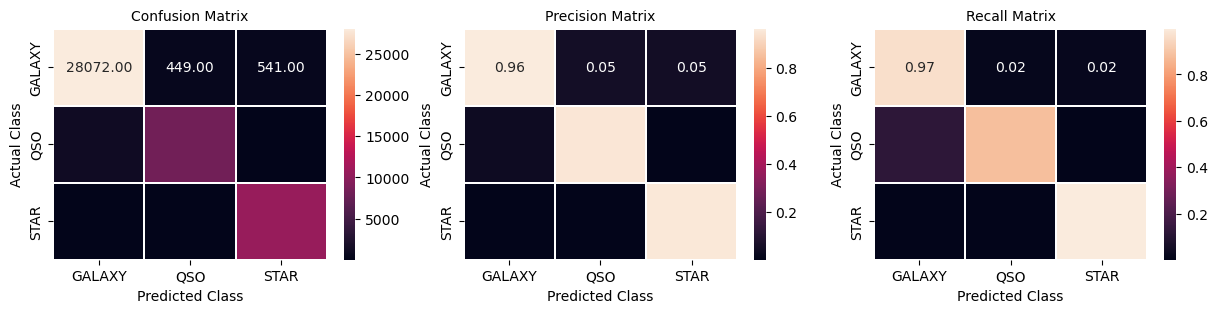

              precision    recall  f1-score   support

      GALAXY       0.96      0.97      0.96     29062
         QSO       0.95      0.88      0.91      9288
        STAR       0.95      1.00      0.97     10650

    accuracy                           0.96     49000
   macro avg       0.95      0.95      0.95     49000
weighted avg       0.96      0.96      0.96     49000

---------------------------------------------------------------------------------
VALID
Accuracy:  0.9544
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


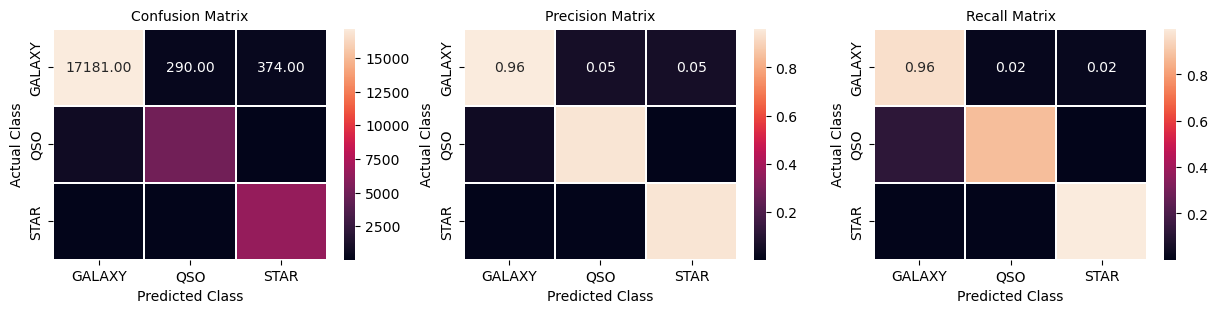

              precision    recall  f1-score   support

      GALAXY       0.96      0.96      0.96     17845
         QSO       0.94      0.88      0.91      5700
        STAR       0.94      1.00      0.97      6455

    accuracy                           0.95     30000
   macro avg       0.95      0.95      0.95     30000
weighted avg       0.95      0.95      0.95     30000

---------------------------------------------------------------------------------
Cross-validation scores:  [0.95622449 0.95571429 0.95591837 0.9544898  0.95836735]
Mean CV score:  0.9561428571428572
---------------------------------------------------------------------------------
Cross-validation scores for validation data:  [0.94916667 0.95466667 0.952      0.95616667 0.95166667]
Mean CV score for validation data:  0.9527333333333334
---------------------------------------------------------------------------------
ROC curve and AUC for each class


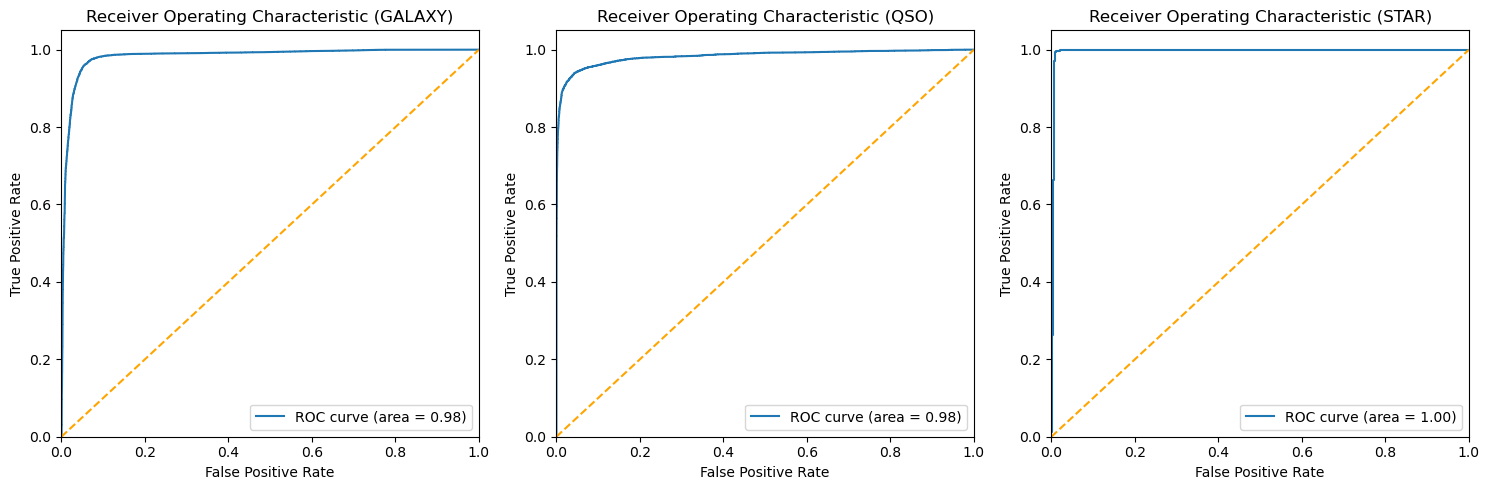

In [32]:
# logistic regression
lg = LogisticRegression(max_iter=1000)
# dist = dict(C=[10 ** x for x in range(-4, 3)], penalty=['l2', 'l1'])
# lg_best_params, lg_train_accuracy, lg_test_accuracy, lg_cv_scores, lg_cv_test_scores = train_and_evaluate_model(lg, param_grid=dist, X_train=X, y_train=y, X_test=X_test, y_test=y_test)
lg_best_params = {'penalty': 'l2', 'C': 100}
lg_train_accuracy, lg_valid_accuracy, lg_cv_scores, lg_cv_valid_scores = train_and_validate_model(lg, best_params=lg_best_params, X_train=X, y_train=y, X_valid=X_valid, y_valid=y_valid)


*Wnioski:*
* *Otrzymane wyniki wskaźnika accuracy dla danych walidacyjnych są zbliżone do wyników dla danych treningowych. Model został wytrenowany poprawnie, nie doszło do overfittingu.*
* *Wskaźniki recall i f1-score również znajdują się na wysokim poziomie (>0.9).*
* *Wskaźniki cross-validation score w okolicy 0.95 zarówno dla danych treningowych, jak i walidacyjnych.*
* *Wskaźnik ROC-AUC również na poziomie zbliżonym do 1.*

### SHAP

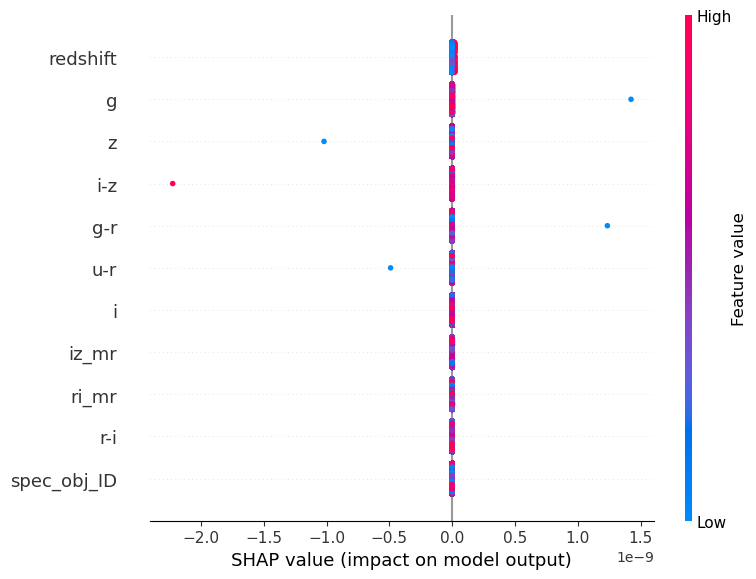

In [33]:
# SHAP value
explainer = shap.LinearExplainer(lg, X)
# shap_values = explainer.shap_values(X_test)
shap_values = explainer.shap_values(X_valid)

# Sum up the SHAP values for all classes
shap_values_sum = shap_values.sum(axis=2)

# Generate SHAP plot
# shap.summary_plot(shap_values_sum, X_test, feature_names=X.columns, max_display=X_test.shape[1])
shap.summary_plot(shap_values_sum, X_valid, feature_names=X.columns, max_display=X_valid.shape[1])


In [34]:
shap.initjs()
# Generate force plot for the first observation and the first class ('GALAXY')
print("GALAXY")
# shap.force_plot(explainer.expected_value[0], shap_values[0,:,0], X_test.iloc[0,:], feature_names=X.columns)
shap.force_plot(explainer.expected_value[0], shap_values[0,:,0], X_valid.iloc[0,:], feature_names=X.columns)

GALAXY


In [35]:

# Generate force plot for the first observation and the second class ('QSO')
print("QSO")
# shap.force_plot(explainer.expected_value[1], shap_values[0,:,1], X_test.iloc[0,:], feature_names=X.columns)
shap.force_plot(explainer.expected_value[1], shap_values[0,:,1], X_valid.iloc[0,:], feature_names=X.columns)

QSO


In [36]:
# Generate force plot for the first observation and the third class ('STAR')
print("STAR")
# shap.force_plot(explainer.expected_value[2], shap_values[0,:,2], X_test.iloc[0,:], feature_names=X.columns)
shap.force_plot(explainer.expected_value[2], shap_values[0,:,2], X_valid.iloc[0,:], feature_names=X.columns)

STAR


### 4.2. Random forest 

TRAIN
Accuracy:  0.9988163265306123
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


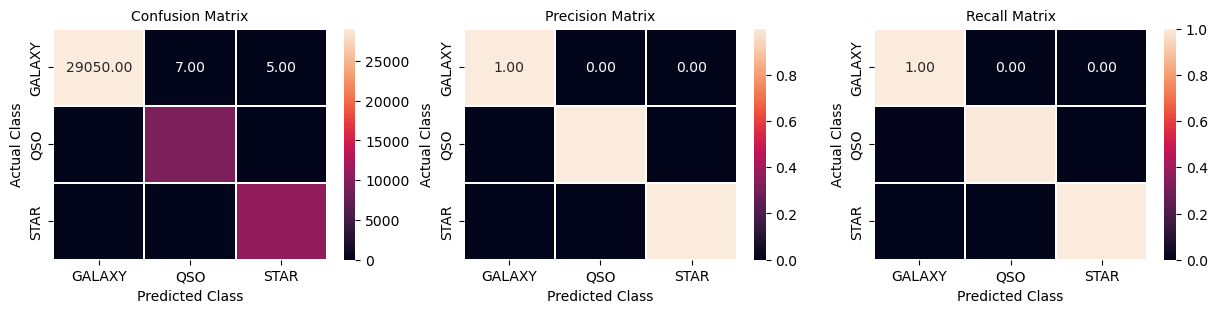

              precision    recall  f1-score   support

      GALAXY       1.00      1.00      1.00     29062
         QSO       1.00      1.00      1.00      9288
        STAR       1.00      1.00      1.00     10650

    accuracy                           1.00     49000
   macro avg       1.00      1.00      1.00     49000
weighted avg       1.00      1.00      1.00     49000

---------------------------------------------------------------------------------
VALID
Accuracy:  0.9777666666666667
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


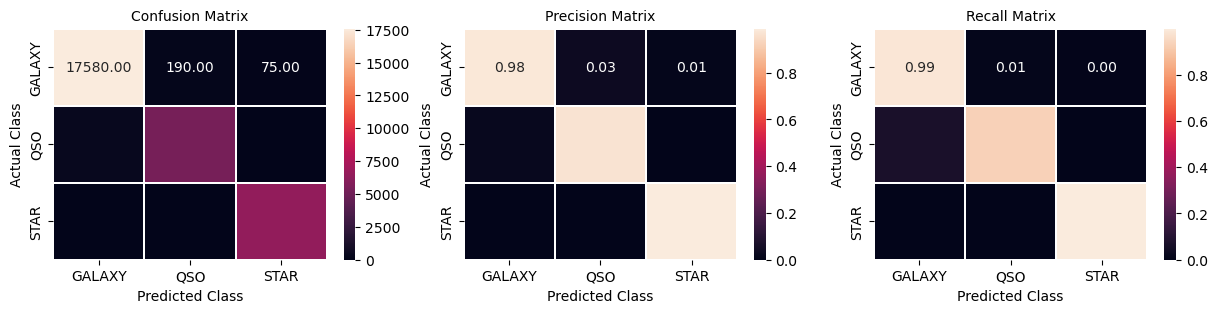

              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.98     17845
         QSO       0.97      0.93      0.95      5700
        STAR       0.99      1.00      0.99      6455

    accuracy                           0.98     30000
   macro avg       0.98      0.97      0.97     30000
weighted avg       0.98      0.98      0.98     30000

---------------------------------------------------------------------------------
Cross-validation scores:  [0.97755102 0.97683673 0.97938776 0.97877551 0.97765306]
Mean CV score:  0.9780408163265305
---------------------------------------------------------------------------------
Cross-validation scores for validation data:  [0.97516667 0.97666667 0.97766667 0.97833333 0.97716667]
Mean CV score for validation data:  0.977
---------------------------------------------------------------------------------
ROC curve and AUC for each class


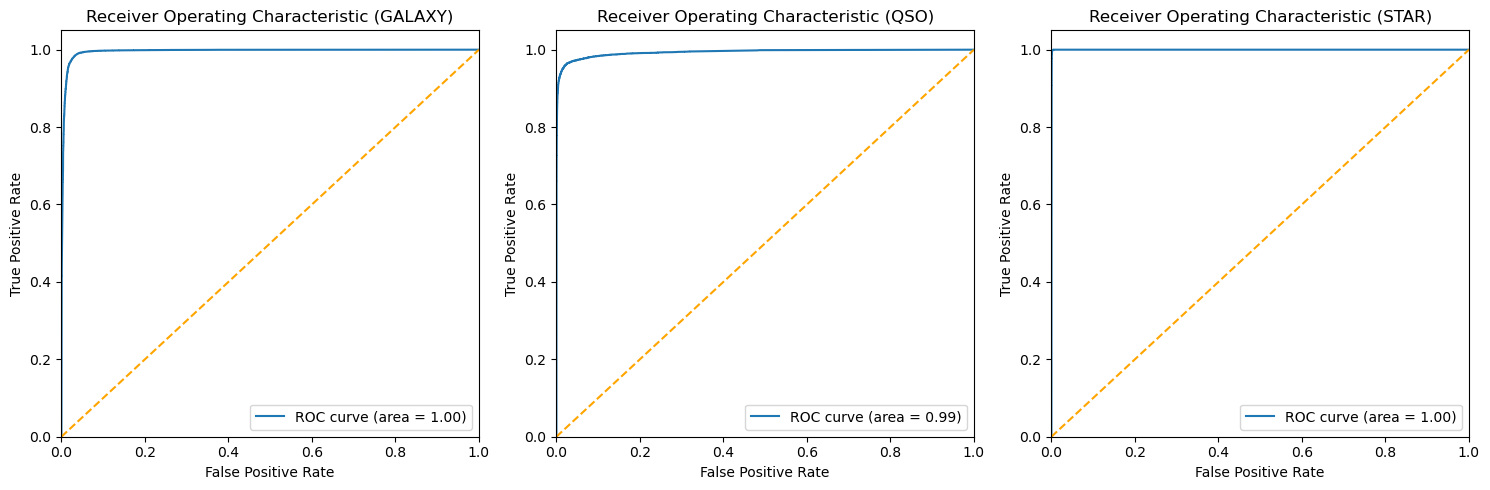

In [37]:
# random forest
rf = RandomForestClassifier(random_state=42)
# dist = dict(n_estimators=[5, 10, 25, 50, 100, 200, 250, 500, 1000],
#             criterion=['gini', 'entropy', 'log_loss'],
#             max_depth=[1, 5, 10, 25, 50, 100, 150],
#             min_samples_split=[1, 5, 10, 25, 50, 100, 250, 500])
# rf_best_params, rf_train_accuracy, rf_test_accuracy, rf_cv_scores, rf_cv_test_scores = train_and_evaluate_model(rf, param_grid=dist, X_train=X, y_train=y, X_test=X_test, y_test=y_test)
rf_best_params = {'n_estimators': 200, 'min_samples_split': 5, 'max_depth': 25, 'criterion': 'log_loss'}
rf_train_accuracy, rf_valid_accuracy, rf_cv_scores, rf_cv_valid_scores = train_and_validate_model(rf, best_params=rf_best_params, X_train=X, y_train=y, X_valid=X_valid, y_valid=y_valid)

*Wnioski:*
* *W przypadku danych treningowych wszystkie wskaźniki (accuracy, recall, f1-score) są równe 1, model poprawnie sklasyfikował wszystkie dane. Można by spodziewać się overfittingu w przypadku danych walidacyjnych, ale tam również model wykazuje wysoką skuteczność - na poziomie >0.9.*
* *Wskaźniki cross-validation score na poziomie około 0.97 zarówno dla danych treningowych, jak i walidacyjnych.*
* *Wskaźniki ROC-AUC dla każdej z klas również są zbliżone do 1.*

### SHAP

In [38]:
# SHAP value
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_valid)

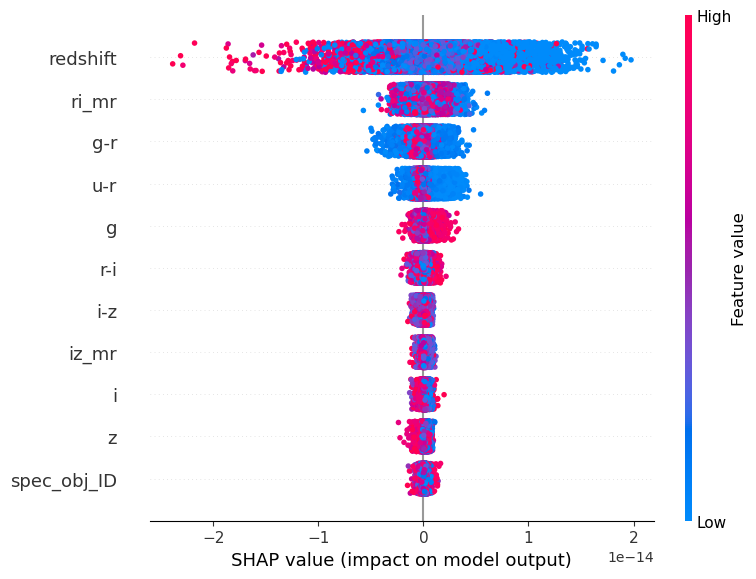

In [39]:
# Sum up the SHAP values for all classes
shap_values_sum = shap_values.sum(axis=2)

# Generowanie wykresu podsumowującego wpływ cech na predykcje modelu
shap.summary_plot(shap_values_sum, X_valid)

In [40]:
# Generate force plot for the first observation and the first class ('GALAXY')
print("GALAXY")
shap.force_plot(explainer.expected_value[0], shap_values[0,:,0], X_valid.iloc[0,:], feature_names=X.columns)

GALAXY


In [41]:
# Generate force plot for the first observation and the first class ('QSO')
print("QSO")
shap.force_plot(explainer.expected_value[0], shap_values[0,:,1], X_valid.iloc[0,:], feature_names=X.columns)

QSO


In [42]:
# Generate force plot for the first observation and the first class ('STAR')
print("STAR")
shap.force_plot(explainer.expected_value[0], shap_values[0,:,2], X_valid.iloc[0,:], feature_names=X.columns)

STAR


### 4.3. Naive Bayes

TRAIN
Accuracy:  0.9273469387755102
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


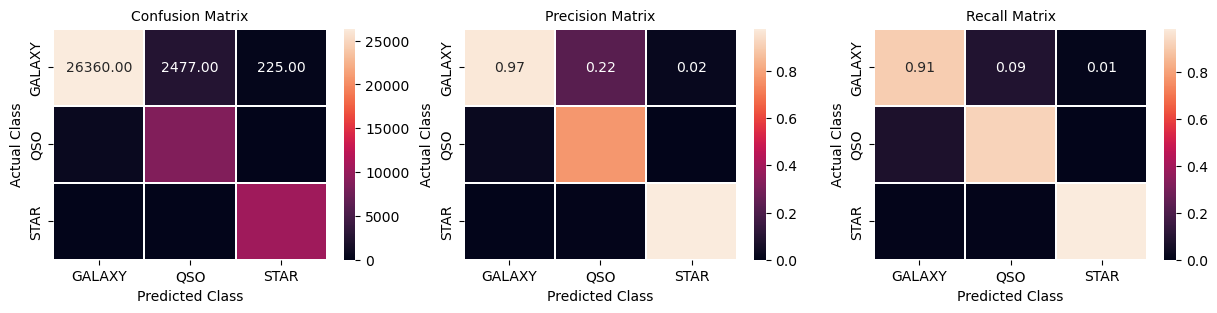

              precision    recall  f1-score   support

      GALAXY       0.97      0.91      0.94     29062
         QSO       0.77      0.92      0.84      9288
        STAR       0.98      0.99      0.98     10650

    accuracy                           0.93     49000
   macro avg       0.91      0.94      0.92     49000
weighted avg       0.93      0.93      0.93     49000

---------------------------------------------------------------------------------
VALID
Accuracy:  0.9269666666666667
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


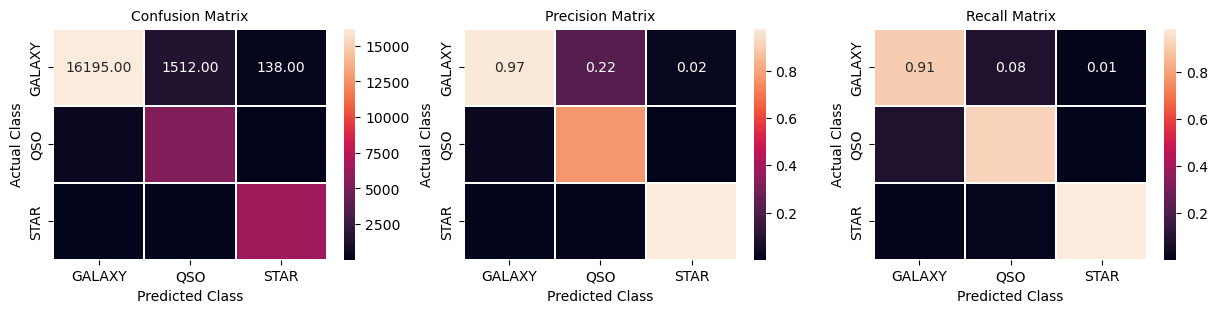

              precision    recall  f1-score   support

      GALAXY       0.97      0.91      0.94     17845
         QSO       0.77      0.92      0.84      5700
        STAR       0.98      0.98      0.98      6455

    accuracy                           0.93     30000
   macro avg       0.91      0.94      0.92     30000
weighted avg       0.93      0.93      0.93     30000

---------------------------------------------------------------------------------
Cross-validation scores:  [0.9277551  0.92683673 0.92346939 0.92857143 0.92969388]
Mean CV score:  0.9272653061224491
---------------------------------------------------------------------------------
Cross-validation scores for validation data:  [0.7205     0.72466667 0.7165     0.7205     0.927     ]
Mean CV score for validation data:  0.7618333333333334
---------------------------------------------------------------------------------
ROC curve and AUC for each class


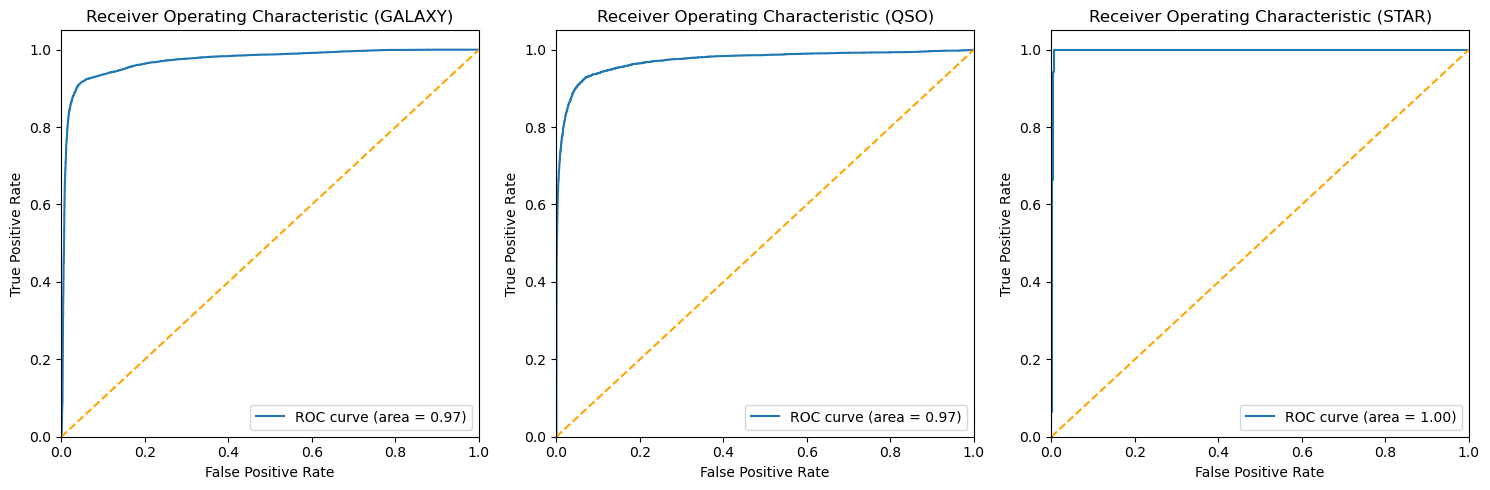

In [43]:
nb = GaussianNB()
# dist = {'var_smoothing': np.logspace(0,-9, num=100)}
# nb_best_params, nb_train_accuracy, nb_test_accuracy, nb_cv_scores, nb_cv_test_scores = train_and_evaluate_model(nb, param_grid=dist, X_train=X, y_train=y, X_test=X_test, y_test=y_test)
nb_best_params = {'var_smoothing': 5.336699231206302e-08}
nb_train_accuracy, nb_valid_accuracy, nb_cv_scores, nb_cv_valid_scores = train_and_validate_model(nb, best_params=nb_best_params, X_train=X, y_train=y, X_valid=X_valid, y_valid=y_valid)

*Wnioski:*
* *Wyniki dla wskaźników accuracy, f1-score oraz recall są identyczne dla danych treningowych i walidacyjnych.*
* *Wskaźniki cross-validation score są na wysokim poziomie dla danych treningowych (ponad 0.92), jednak znacząco niższe dla danych walidacyjnych (około 0.7). Może to świadczyć o gorszym dostosowaniu modelu dla nowych danych.*
* *Wskaźniki ROC-AUC zbliżone do 1.*

### SHAP

In [44]:
# Generate background samples based on training data
background = shap.sample(X, 20)

# Create SHAP explainer for GaussianNB model
explainer = shap.KernelExplainer(nb.predict_proba, background)

# SHAP values for GaussianNB model
shap_values = explainer.shap_values(X_valid)

  0%|          | 0/30000 [00:00<?, ?it/s]

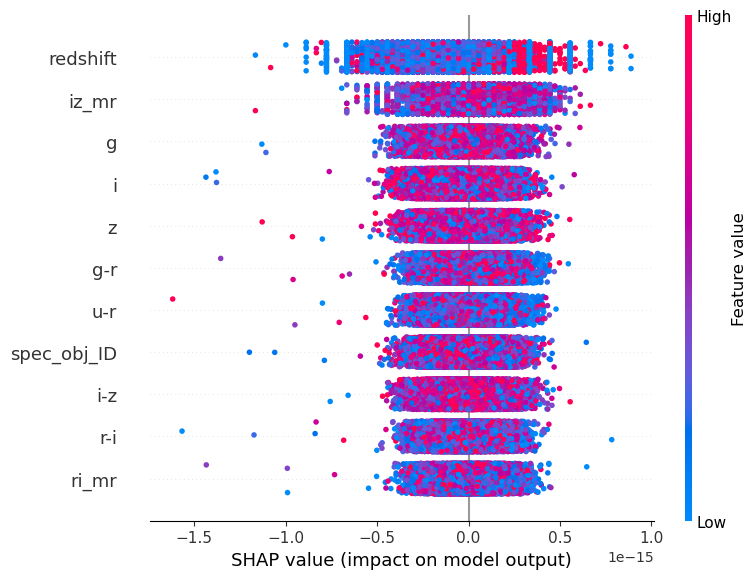

In [45]:
# Sum up the SHAP values for all classes
shap_values_sum = shap_values.sum(axis=2)

# Generowanie wykresu podsumowującego wpływ cech na predykcje modelu
shap.summary_plot(shap_values_sum, X_valid)

In [46]:
# Generate force plot for the first observation and the first class ('GALAXY')
print("GALAXY")
shap.force_plot(explainer.expected_value[0], shap_values[0,:,0], X_valid.iloc[0,:], feature_names=X.columns)

GALAXY


In [47]:
# Generate force plot for the first observation and the first class ('QSO')
print("")
shap.force_plot(explainer.expected_value[0], shap_values[0,:,1], X_valid.iloc[0,:], feature_names=X.columns)

In [48]:
# Generate force plot for the first observation and the first class ('STAR')
print("STAR")
shap.force_plot(explainer.expected_value[0], shap_values[0,:,2], X_valid.iloc[0,:], feature_names=X.columns)

STAR


### 4.4. K Neighbours

TRAIN
Accuracy:  0.965204081632653
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


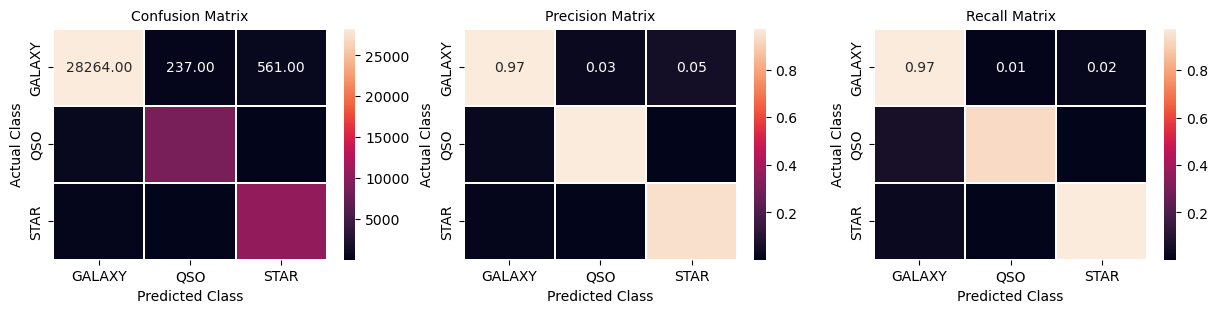

              precision    recall  f1-score   support

      GALAXY       0.97      0.97      0.97     29062
         QSO       0.97      0.93      0.95      9288
        STAR       0.95      0.97      0.96     10650

    accuracy                           0.97     49000
   macro avg       0.96      0.96      0.96     49000
weighted avg       0.97      0.97      0.97     49000

---------------------------------------------------------------------------------
VALID
Accuracy:  0.9559666666666666
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


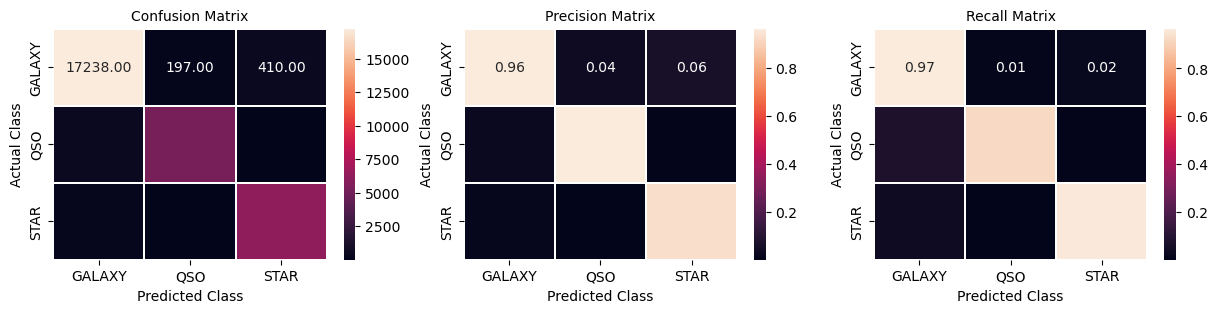

              precision    recall  f1-score   support

      GALAXY       0.96      0.97      0.96     17845
         QSO       0.96      0.92      0.94      5700
        STAR       0.93      0.96      0.95      6455

    accuracy                           0.96     30000
   macro avg       0.95      0.95      0.95     30000
weighted avg       0.96      0.96      0.96     30000

---------------------------------------------------------------------------------
Cross-validation scores:  [0.95653061 0.95132653 0.95479592 0.95357143 0.95285714]
Mean CV score:  0.9538163265306123
---------------------------------------------------------------------------------
Cross-validation scores for validation data:  [0.95066667 0.948      0.951      0.95283333 0.94816667]
Mean CV score for validation data:  0.9501333333333333
---------------------------------------------------------------------------------
ROC curve and AUC for each class


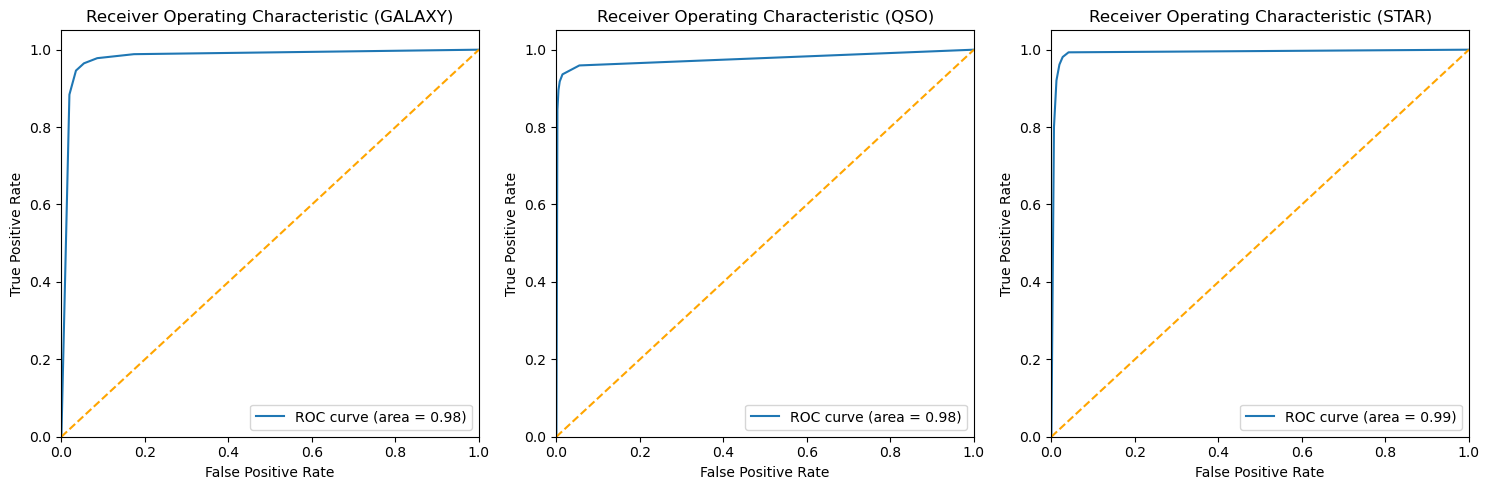

In [49]:
knn = KNeighborsClassifier()
# dist = {'n_neighbors': [3, 5, 9, 15, 21, 31, 41, 51, 71, 99]}
# knn_best_params, knn_train_accuracy, knn_test_accuracy, knn_cv_scores, knn_cv_test_scores = train_and_evaluate_model(knn, param_grid=dist, X_train=X, y_train=y, X_test=X_test, y_test=y_test)
knn_best_params = {'n_neighbors': 5}
knn_train_accuracy, knn_valid_accuracy, knn_cv_scores, knn_cv_valid_scores = train_and_validate_model(knn, best_params=knn_best_params, X_train=X, y_train=y, X_valid=X_valid, y_valid=y_valid)

*Wnioski:*
* *Wyniki dla wskaźników accuracy, f1-score oraz recall są na wysokim poziomie (>0.9) dla danych treningowych i walidacyjnych.*
* *Wskaźniki cross-validation score są na wysokim poziomie zarówno dla danych treningowych, jak i walidacyjnych (ponad 0.9).*
* *Wskaźniki ROC-AUC zbliżone do 1.*

### SHAP

In [50]:
# Generate background samples based on training data
background = shap.kmeans(X, 1)

# Create the KernelExplainer
explainer = shap.KernelExplainer(knn.predict_proba, background)

# Calculate shap_values
shap_values = explainer.shap_values(X_valid)

  0%|          | 0/30000 [00:00<?, ?it/s]

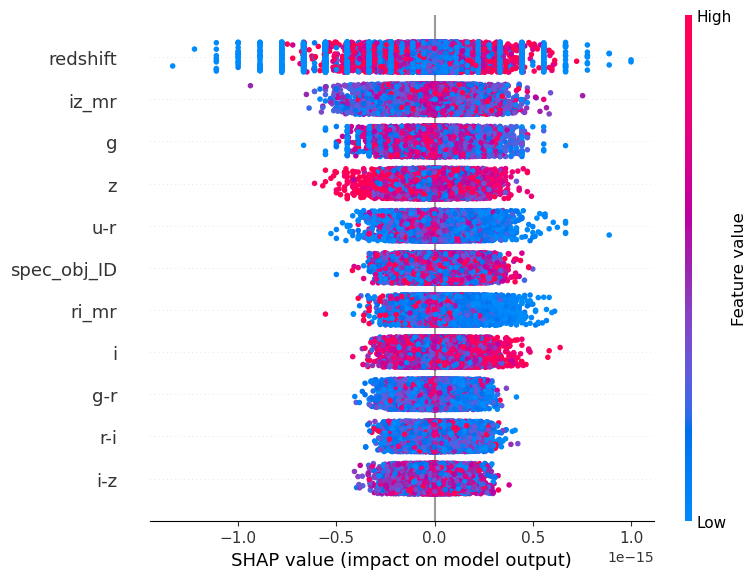

In [52]:
# Sum up the SHAP values for all classes
shap_values_sum = shap_values.sum(axis=2)

# Generowanie wykresu podsumowującego wpływ cech na predykcje modelu
shap.summary_plot(shap_values_sum, X_valid)

In [53]:
# Generate force plot for the first observation and the first class ('GALAXY')
print("GALAXY")
shap.force_plot(explainer.expected_value[0], shap_values[0,:,0], X_valid.iloc[0,:], feature_names=X.columns)

GALAXY


In [54]:
# Generate force plot for the first observation and the first class ('QSO')
print("QSO")
shap.force_plot(explainer.expected_value[0], shap_values[0,:,1], X_valid.iloc[0,:], feature_names=X.columns)

QSO


In [56]:
# Generate force plot for the first observation and the first class ('STAR')
print("STAR")
shap.force_plot(explainer.expected_value[0], shap_values[0,:,2], X_valid.iloc[0,:], feature_names=X.columns)

STAR


### 4.5. Drzewa decyzyjne

TRAIN
Accuracy:  0.9821224489795919
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


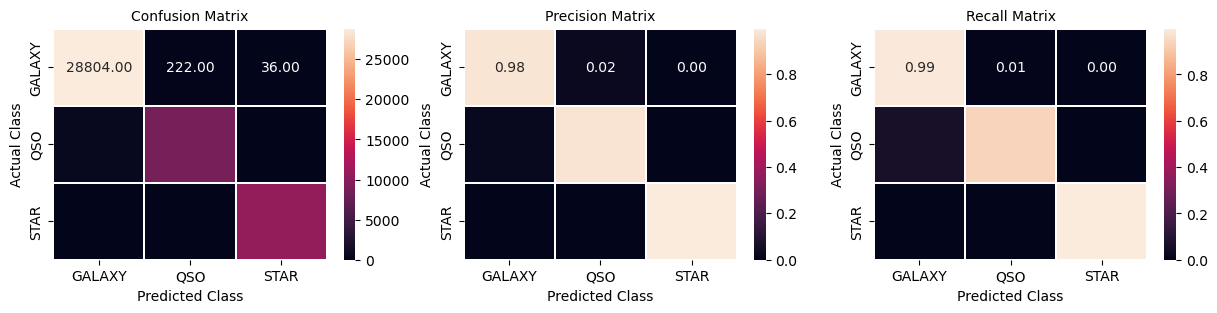

              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.99     29062
         QSO       0.98      0.94      0.96      9288
        STAR       1.00      1.00      1.00     10650

    accuracy                           0.98     49000
   macro avg       0.98      0.97      0.98     49000
weighted avg       0.98      0.98      0.98     49000

---------------------------------------------------------------------------------
VALID
Accuracy:  0.9722333333333333
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


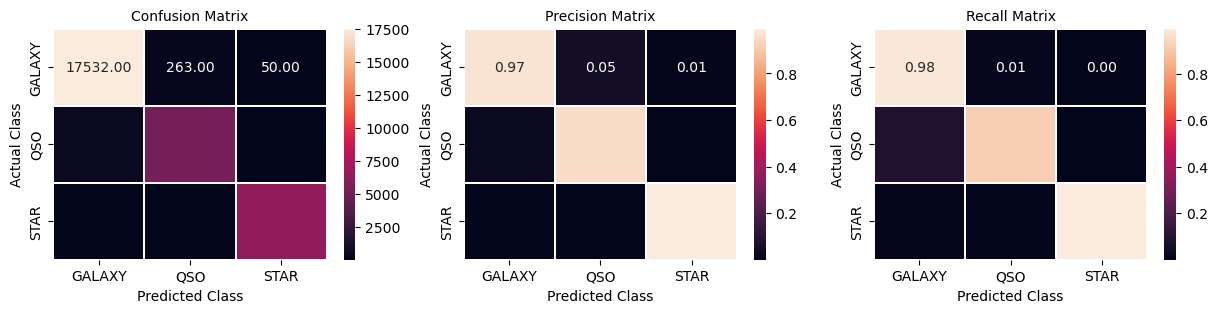

              precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.98     17845
         QSO       0.95      0.92      0.93      5700
        STAR       0.99      0.99      0.99      6455

    accuracy                           0.97     30000
   macro avg       0.97      0.96      0.97     30000
weighted avg       0.97      0.97      0.97     30000

---------------------------------------------------------------------------------
Cross-validation scores:  [0.97397959 0.97       0.97377551 0.97071429 0.97316327]
Mean CV score:  0.9723265306122449
---------------------------------------------------------------------------------
Cross-validation scores for validation data:  [0.9695     0.9735     0.973      0.97166667 0.96833333]
Mean CV score for validation data:  0.9712
---------------------------------------------------------------------------------
ROC curve and AUC for each class


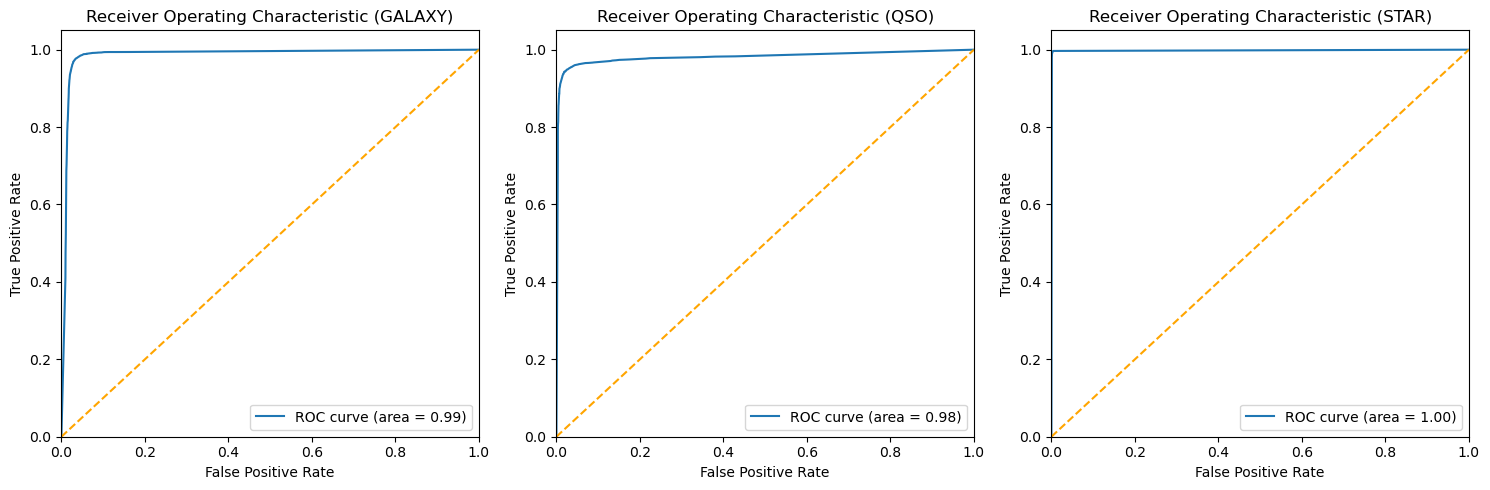

In [57]:
dt = DecisionTreeClassifier()
# dist  = dict(criterion=['gini', 'entropy', 'log_loss'],
#             max_depth=[1, 5, 10, 50, 75, 100],
#             min_samples_split=[5, 10, 100, 250, 500])
# dt_best_params, dt_train_accuracy, dt_test_accuracy, dt_cv_scores, dt_cv_test_scores = train_and_evaluate_model(dt, param_grid=dist, X_train=X, y_train=y, X_test=X_test, y_test=y_test)     
dt_best_params = {'min_samples_split': 5, 'max_depth': 10, 'criterion': 'entropy'}
dt_train_accuracy, dt_valid_accuracy, dt_cv_scores, dt_cv_valid_scores = train_and_validate_model(dt, best_params=dt_best_params, X_train=X, y_train=y, X_valid=X_valid, y_valid=y_valid)

*Wnioski:*
* *Wyniki dla wskaźników accuracy, f1-score oraz recall są na wysokim poziomie, zbliżonym do 1, i dla danych treningowych, i walidacyjnych.*
* *Wskaźniki cross-validation score są na wysokim poziomie zarówno dla danych treningowych, jak i walidacyjnych (ponad 0.9).*
* *Wskaźniki ROC-AUC zbliżone do 1.*

### SHAP

In [64]:
# Create the TreeExplainer
explainer = shap.TreeExplainer(dt)

# Calculate shap_values
shap_values = explainer.shap_values(X_valid)

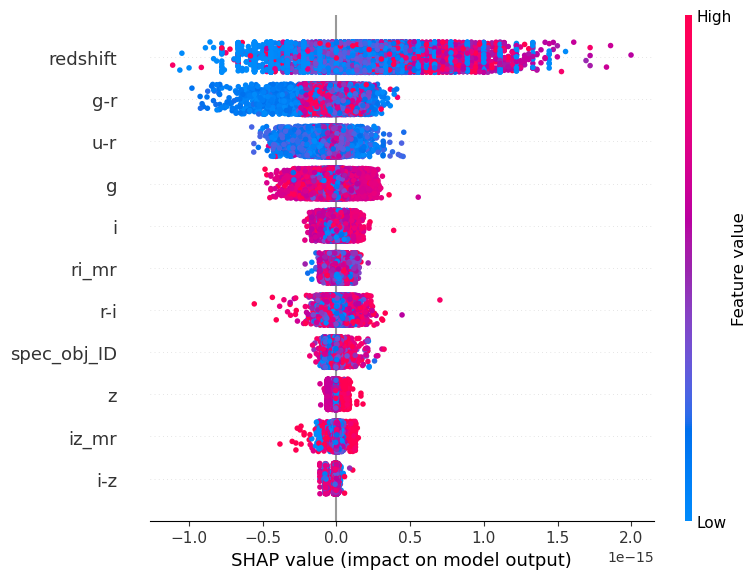

In [65]:
# Sum up the SHAP values for all classes
shap_values_sum = shap_values.sum(axis=2)

# Generowanie wykresu podsumowującego wpływ cech na predykcje modelu
shap.summary_plot(shap_values_sum, X_valid)

In [66]:
# Generate force plot for the first observation and the first class ('GALAXY')
print("GALAXY")
shap.force_plot(explainer.expected_value[0], shap_values[0,:,0], X_valid.iloc[0,:], feature_names=X.columns)

GALAXY


In [67]:
# Generate force plot for the first observation and the first class ('QSO')
print("QSO")
shap.force_plot(explainer.expected_value[0], shap_values[0,:,1], X_valid.iloc[0,:], feature_names=X.columns)

QSO


In [68]:
# Generate force plot for the first observation and the first class ('STAR')
print("STAR")
shap.force_plot(explainer.expected_value[0], shap_values[0,:,2], X_valid.iloc[0,:], feature_names=X.columns)

STAR


### 4.6. Ada boost classifier

TRAIN
Accuracy:  0.805265306122449
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


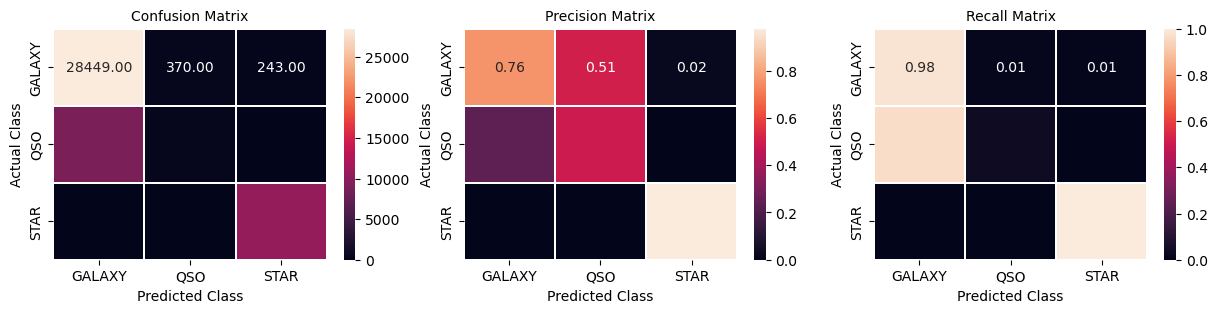

              precision    recall  f1-score   support

      GALAXY       0.76      0.98      0.86     29062
         QSO       0.49      0.04      0.07      9288
        STAR       0.98      1.00      0.99     10650

    accuracy                           0.81     49000
   macro avg       0.74      0.67      0.64     49000
weighted avg       0.76      0.81      0.74     49000

---------------------------------------------------------------------------------
VALID
Accuracy:  0.8045
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


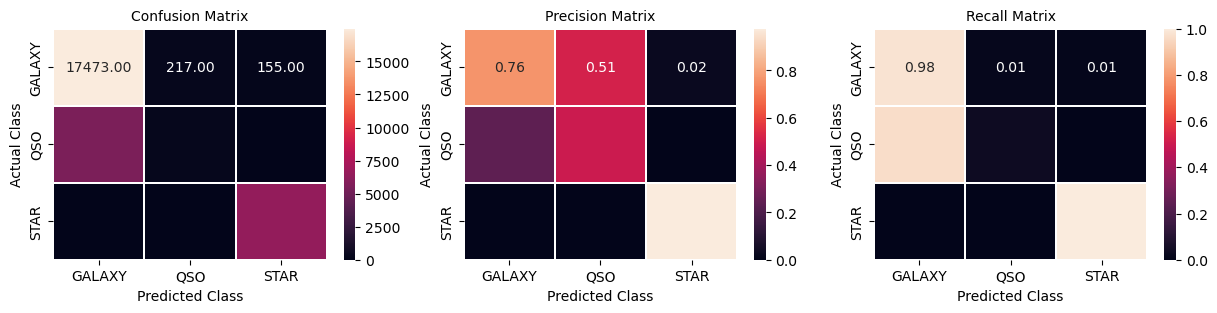

              precision    recall  f1-score   support

      GALAXY       0.76      0.98      0.86     17845
         QSO       0.49      0.04      0.07      5700
        STAR       0.98      1.00      0.99      6455

    accuracy                           0.80     30000
   macro avg       0.74      0.67      0.64     30000
weighted avg       0.76      0.80      0.73     30000

---------------------------------------------------------------------------------
Cross-validation scores:  [0.81438776 0.81102041 0.80091837 0.8072449  0.80663265]
Mean CV score:  0.8080408163265306
---------------------------------------------------------------------------------
Cross-validation scores for validation data:  [0.79916667 0.801      0.80533333 0.80066667 0.80133333]
Mean CV score for validation data:  0.8014999999999999
---------------------------------------------------------------------------------
ROC curve and AUC for each class


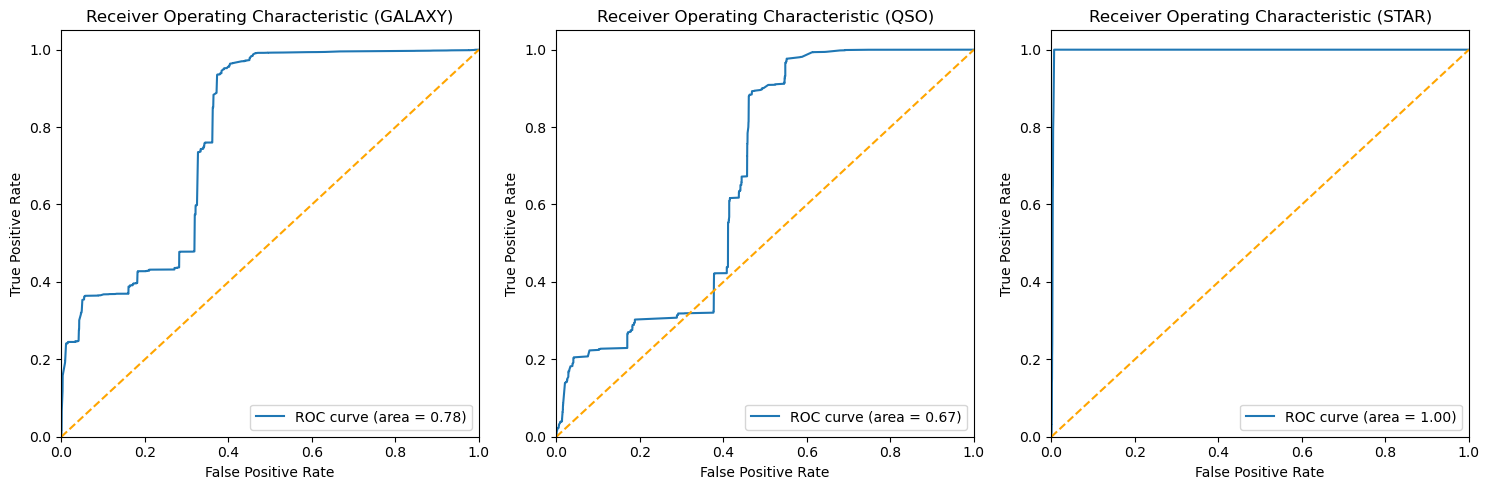

In [58]:
ab = AdaBoostClassifier()
# grid = dict()
# grid['n_estimators'] = [10, 50, 100, 500]
# grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
# ab_best_params, ab_train_accuracy, ab_test_accuracy, ab_cv_scores, ab_cv_test_scores = train_and_evaluate_model(ab, param_grid=grid, X_train=X, y_train=y, X_test=X_test, y_test=y_test)
ab_best_params = {'n_estimators': 500, 'learning_rate': 0.01}
ab_train_accuracy, ab_valid_accuracy, ab_cv_scores, ab_cv_valid_scores = train_and_validate_model(ab, best_params=ab_best_params, X_train=X, y_train=y, X_valid=X_valid, y_valid=y_valid)

*Wnioski:*
* *Wyniki dla wskaźników accuracy, f1-score oraz recall są identyczne pomiędzy danymi treningowymi i walidacyjnymi. Widać, że model ma problem z rozpoznawaniem obiektów z klasy QSO. W przypadku obiektów klasy GALAXY pojawiło się więcej False Positives i False Negatives niż we wcześniej analizowanych modelach.*
* *Wskaźniki cross-validation score są na dość wysokim poziomie (ok. 0.8) zarówno dla danych treningowych, jak i walidacyjnych, jednak jest on niższy niż w przypadku wcześniej analizowanych modeli. Ada boost classifier radzi sobie gorzej z klasyfikacją obiektów kosmicznych.*
* *Wskaźniki ROC-AUC dla klas GALAXY i QSO zaniżone, choć nadal wysokie (0.7-0.8), dla klasy STAR równy 1.*

### SHAP

In [69]:
# Generate background samples based on training data
background = shap.kmeans(X, 1)

# Create the KernelExplainer
explainer = shap.KernelExplainer(ab.predict_proba, background)

# Calculate shap_values
shap_values = explainer.shap_values(X_valid)

  0%|          | 0/30000 [00:00<?, ?it/s]

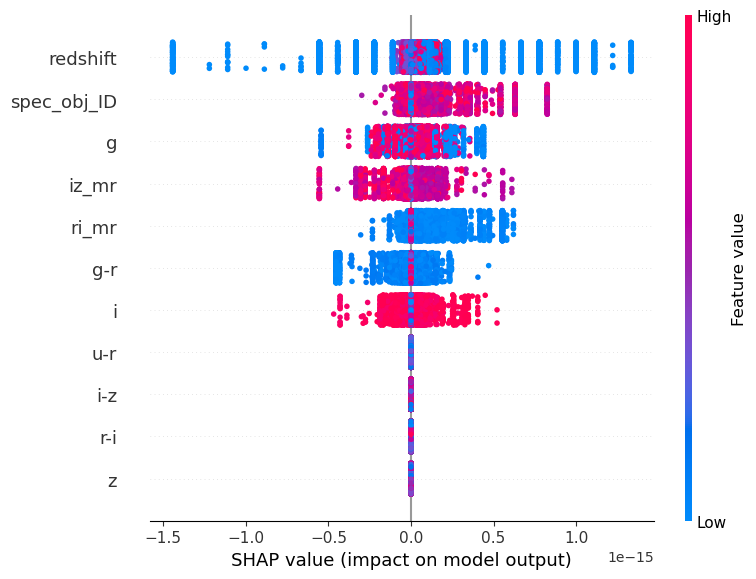

In [70]:
# Sum up the SHAP values for all classes
shap_values_sum = shap_values.sum(axis=2)

# Generowanie wykresu podsumowującego wpływ cech na predykcje modelu
shap.summary_plot(shap_values_sum, X_valid)

In [71]:
# Generate force plot for the first observation and the first class ('GALAXY')
print("GALAXY")
shap.force_plot(explainer.expected_value[0], shap_values[0,:,0], X_valid.iloc[0,:], feature_names=X.columns)

GALAXY


In [72]:
# Generate force plot for the first observation and the first class ('QSO')
print("QSO")
shap.force_plot(explainer.expected_value[0], shap_values[0,:,1], X_valid.iloc[0,:], feature_names=X.columns)

QSO


In [73]:
# Generate force plot for the first observation and the first class ('STAR')
print("STAR")
shap.force_plot(explainer.expected_value[0], shap_values[0,:,2], X_valid.iloc[0,:], feature_names=X.columns)

STAR


### 4.7. SVC

TRAIN
Accuracy:  0.9735918367346938
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


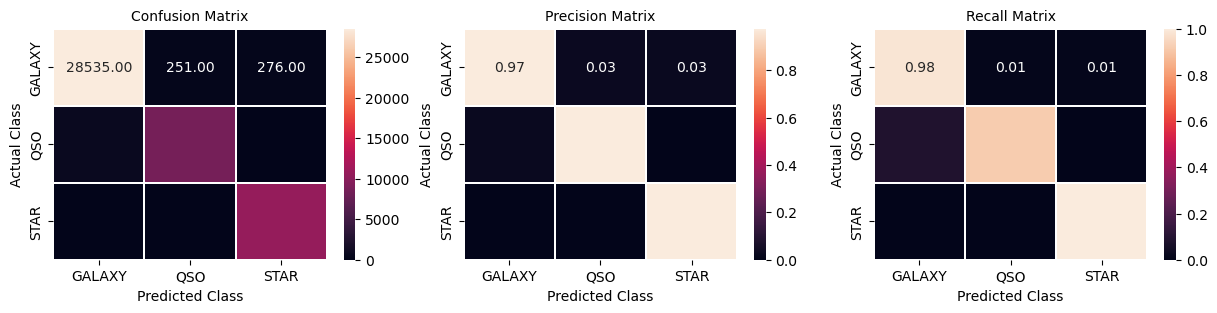

              precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.98     29062
         QSO       0.97      0.92      0.94      9288
        STAR       0.97      1.00      0.99     10650

    accuracy                           0.97     49000
   macro avg       0.97      0.97      0.97     49000
weighted avg       0.97      0.97      0.97     49000

---------------------------------------------------------------------------------
VALID
Accuracy:  0.9727666666666667
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


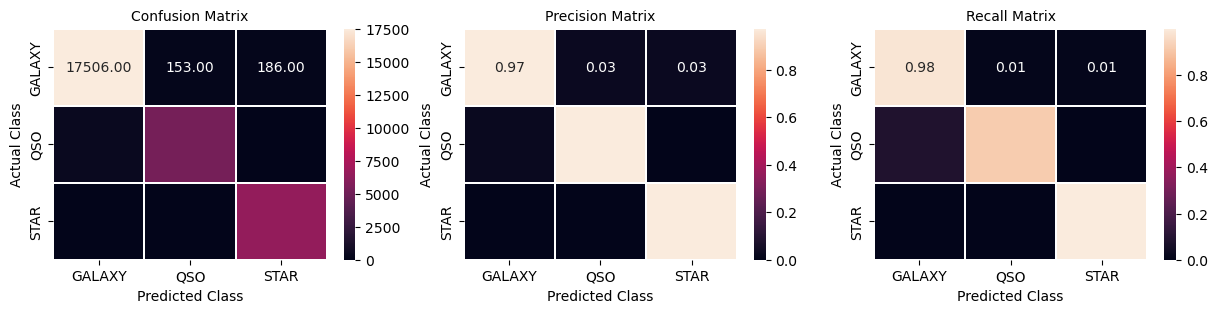

              precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.98     17845
         QSO       0.97      0.92      0.94      5700
        STAR       0.97      1.00      0.99      6455

    accuracy                           0.97     30000
   macro avg       0.97      0.97      0.97     30000
weighted avg       0.97      0.97      0.97     30000

---------------------------------------------------------------------------------
Cross-validation scores:  [0.97153061 0.97122449 0.97285714 0.97214286 0.97193878]
Mean CV score:  0.971938775510204
---------------------------------------------------------------------------------
Cross-validation scores for validation data:  [0.958      0.962      0.96033333 0.964      0.971     ]
Mean CV score for validation data:  0.9630666666666666
---------------------------------------------------------------------------------
ROC curve and AUC for each class


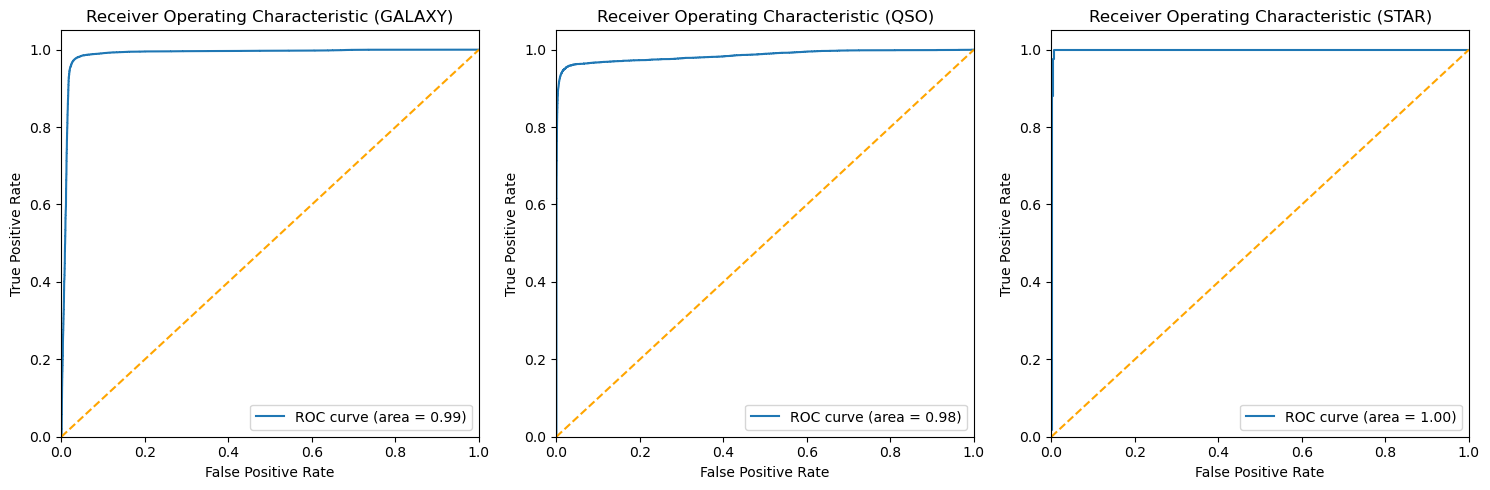

In [61]:
svc = SVC(probability=True)
# dist = {'C': [0.1, 1, 10, 100, 1000]}
# svc_best_params, svc_train_accuracy, svc_test_accuracy, svc_cv_scores, svc_cv_test_scores = train_and_evaluate_model(svc, param_grid=dist, X_train=X, y_train=y, X_test=X_test, y_test=y_test)
svc_best_params = {'C': 1000}
svc_train_accuracy, svc_valid_accuracy, svc_cv_scores, svc_cv_valid_scores = train_and_validate_model(svc, best_params=svc_best_params, X_train=X, y_train=y, X_valid=X_valid, y_valid=y_valid)

*Wnioski:*
* *Wyniki dla wskaźników accuracy, f1-score oraz recall są na wysokim poziomie zarówno dla danych treningowych, jak i walidacyjnych.*
* *Wskaźniki cross-validation score są na wysokim poziomie zarówno danych treningowych i walidacyjnych (ponad 0.9).*
* *Wskaźniki ROC-AUC zbliżone do 1.*

### 4.8. XGBoost

Best hyperparameters:  {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.5}
---------------------------------------------------------------------------------
TRAIN
Accuracy:  0.9981224489795918
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


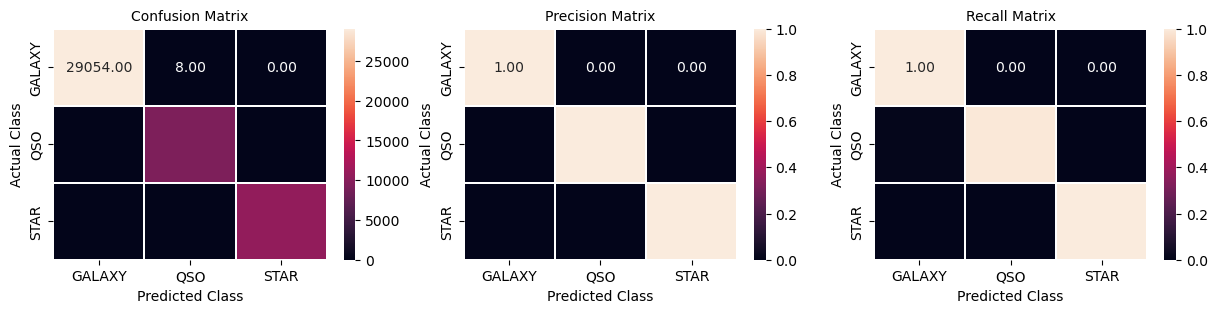

              precision    recall  f1-score   support

      GALAXY       1.00      1.00      1.00     29062
         QSO       1.00      0.99      1.00      9288
        STAR       1.00      1.00      1.00     10650

    accuracy                           1.00     49000
   macro avg       1.00      1.00      1.00     49000
weighted avg       1.00      1.00      1.00     49000

---------------------------------------------------------------------------------
VALID
Accuracy:  0.9777
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


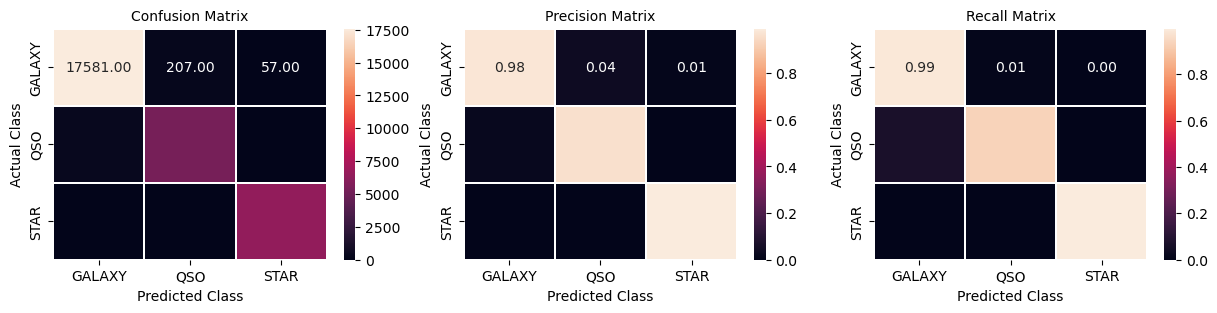

              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.98     17845
         QSO       0.96      0.93      0.95      5700
        STAR       0.99      1.00      0.99      6455

    accuracy                           0.98     30000
   macro avg       0.98      0.97      0.97     30000
weighted avg       0.98      0.98      0.98     30000

---------------------------------------------------------------------------------
Cross-validation scores:  [0.97816327 0.97642857 0.97867347 0.97897959 0.97673469]
Mean CV score:  0.9777959183673468
---------------------------------------------------------------------------------
Cross-validation scores for validation data:  [0.97866667 0.97583333 0.97783333 0.98       0.9765    ]
Mean CV score for validation data:  0.9777666666666667
---------------------------------------------------------------------------------
ROC curve and AUC for each class


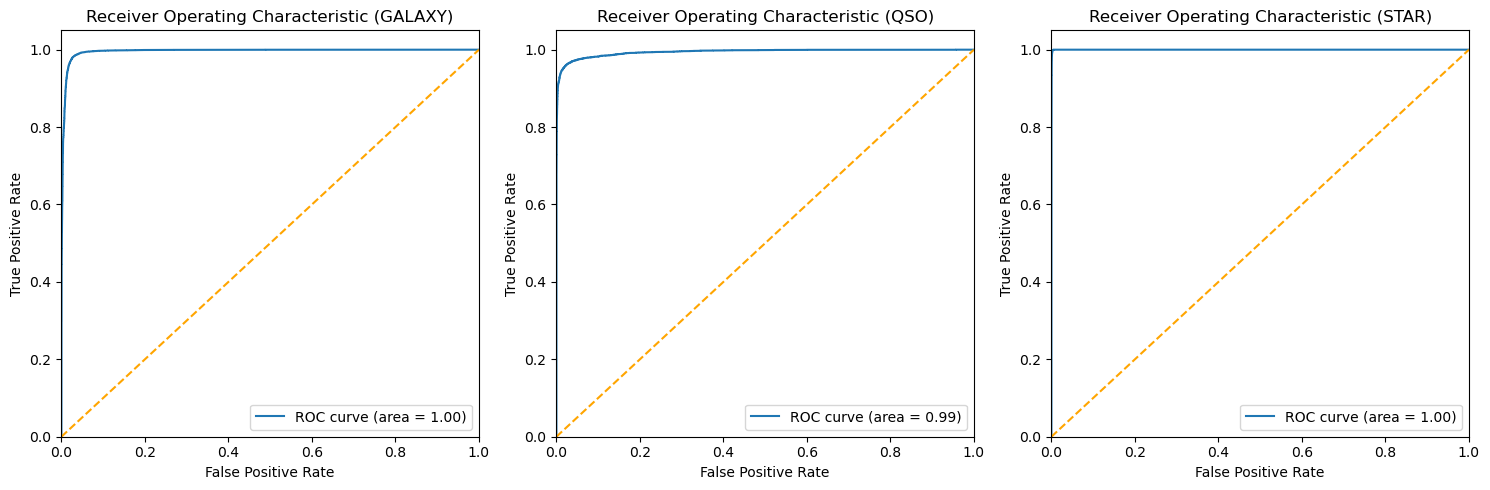

In [62]:
# encoding
label_encoder = LabelEncoder()
y_encoded = y.copy()
y_encoded = label_encoder.fit_transform(y_encoded)
# y_test_encoded = y_test.copy()
# y_test_encoded = label_encoder.fit_transform(y_test_encoded)
y_valid_encoded = y_valid.copy()
y_valid_encoded = label_encoder.fit_transform(y_valid_encoded)

# Define the parameter grid
# param_grid = {
#     'n_estimators': [100, 200, 300],  # Number of boosting rounds
#     'max_depth': [3, 5, 7],  # Maximum depth of the tree
#     'learning_rate': [0.01, 0.1, 0.3],  # Step size shrinkage used in update to prevent overfitting
#     'subsample': [0.5, 0.8, 1.0],  # Subsample ratio of the training instance
#     'colsample_bytree': [0.5, 0.8, 1.0],  # Subsample ratio of columns when constructing each tree
#     'gamma': [0, 0.1, 0.2]  # Minimum loss reduction required to make a further partition on a leaf node of the tree
# }

# Create an instance of XGBClassifier
xgb = XGBClassifier(random_state=42)
# Hyperparameter tuning
# xgb_best_params, _ = tune_hyperparameters(xgb, param_grid, X, y_encoded)
xgb_best_params = {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.5}

# Fit the best model to the training data
best_model = xgb.set_params(**xgb_best_params)
best_model.fit(X, y_encoded)

# Predictions
train_preds = best_model.predict(X)
# test_preds = best_model.predict(X_test)
valid_preds = best_model.predict(X_valid)

# un-encode the predictions
train_preds = label_encoder.inverse_transform(train_preds)
# test_preds = label_encoder.inverse_transform(test_preds)
valid_preds = label_encoder.inverse_transform(valid_preds)

# Calculate accuracy
train_accuracy = accuracy_score(y, train_preds)
# test_accuracy = accuracy_score(y_test, test_preds)
valid_accuracy = accuracy_score(y_valid, valid_preds)

# Cross-validation
cv_scores = cross_val_score(best_model, X, y_encoded, cv=5)
# cv_test_scores = cross_val_score(best_model, X_test, y_test_encoded, cv=5)
cv_valid_scores = cross_val_score(best_model, X_valid, y_valid_encoded, cv=5)

# print best params 
print("Best hyperparameters: ", xgb_best_params)
print("---------------------------------------------------------------------------------")
# Report for train
print("TRAIN")
print("Accuracy: ", train_accuracy)
plot_confusion_matrix(y, train_preds, labels=['GALAXY', 'QSO', 'STAR'])
print(classification_report(y, train_preds, target_names=['GALAXY', 'QSO', 'STAR']))
print("---------------------------------------------------------------------------------")

# Report for test
# print("TEST")
# print("Accuracy: ", test_accuracy)
# plot_confusion_matrix(y_test, test_preds, labels=['GALAXY', 'QSO', 'STAR'])
# print(classification_report(y_test, test_preds, target_names=['GALAXY', 'QSO', 'STAR']))
# print("---------------------------------------------------------------------------------")

# Report for valid
print("VALID")
print("Accuracy: ", valid_accuracy)
plot_confusion_matrix(y_valid, valid_preds, labels=['GALAXY', 'QSO', 'STAR'])
print(classification_report(y_valid, valid_preds, target_names=['GALAXY', 'QSO', 'STAR']))
print("---------------------------------------------------------------------------------")

# Cross-validation scores
print("Cross-validation scores: ", cv_scores)
print("Mean CV score: ", np.mean(cv_scores))    
print("---------------------------------------------------------------------------------")
# print("Cross-validation scores for test data: ", cv_test_scores)
# print("Mean CV score for test data: ", np.mean(cv_test_scores))
print("Cross-validation scores for validation data: ", cv_valid_scores)
print("Mean CV score for validation data: ", np.mean(cv_valid_scores))

# Plot ROC curve for each class and calculate AUC
print("---------------------------------------------------------------------------------")
print("ROC curve and AUC for each class")
_, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axs):
    # y_true_binary = (y_test == label_encoder.classes_[i]).astype(int)
    # y_prob = best_model.predict_proba(X_test)[:, i]  # predict_proba
    y_true_binary = (y_valid == label_encoder.classes_[i]).astype(int)
    y_prob = best_model.predict_proba(X_valid)[:, i]  # predict_proba
    plot_roc_curve(y_true_binary, y_prob, class_label=label_encoder.classes_[i], ax=ax)
    
plt.tight_layout()
plt.show()

# svc_best_params, svc_train_accuracy, svc_test_accuracy, svc_cv_scores, svc_cv_test_scores
xgb_train_accuracy = train_accuracy
# xgb_test_accuracy = test_accuracy
xgb_valid_accuracy = valid_accuracy
xgb_cv_scores = cv_scores
# xgb_cv_test_scores = cv_test_scores
xgb_cv_valid_scores = cv_valid_scores

*Wnioski:*
* *Wyniki dla wskaźników accuracy, f1-score oraz recall dla danych treningowych są prawie we wszystkich przypadkach równe 1 - model poradził sobie z poprawnym klasyfikowaniem obiektów kosmicznych prawie dla wszystkich rekordów. Dla danych walidacyjnych wyniki również są wysokie, zatem można wyciągnąć wniosek, że nie doszło do przetrenowania - model działa poprawnie.*
* *Wskaźniki cross-validation score są na wysokim poziomie zarówno danych treningowych i walidacyjnych (ponad 0.9).*
* *Wskaźniki ROC-AUC zbliżone do 1.*

In [74]:
# Create a TreeExplainer object
explainer = shap.TreeExplainer(best_model)

# Calculate shap_values for all of X
shap_values = explainer.shap_values(X_valid)

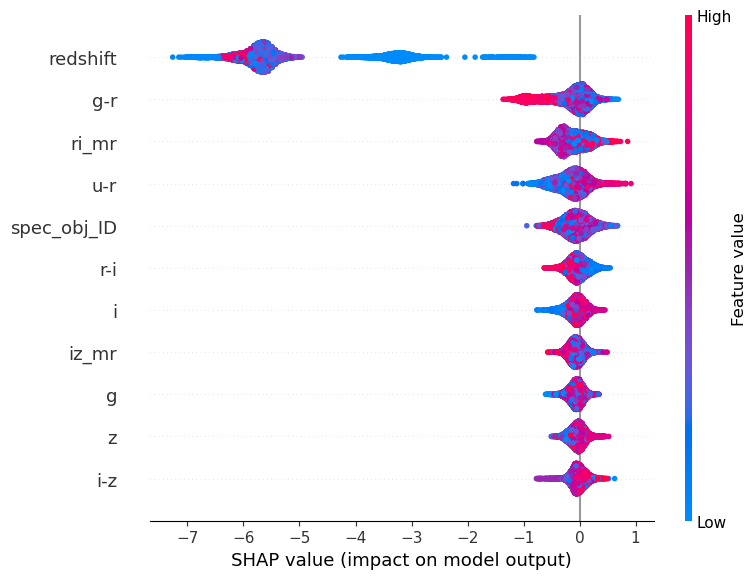

In [75]:
# Sum up the SHAP values for all classes
shap_values_sum = shap_values.sum(axis=2)

# Generate summary plot
shap.summary_plot(shap_values_sum, X_valid)

In [76]:
# Generate force plot for the first observation and the first class ('GALAXY')
print("GALAXY")
shap.force_plot(explainer.expected_value[0], shap_values[0,:,0], X_valid.iloc[0,:], feature_names=X.columns)

GALAXY


In [77]:
# Generate force plot for the first observation and the first class ('QSO')
print("QSO")
shap.force_plot(explainer.expected_value[0], shap_values[0,:,1], X_valid.iloc[0,:], feature_names=X.columns)

QSO


In [78]:
# Generate force plot for the first observation and the first class ('STAR')
print("STAR")
shap.force_plot(explainer.expected_value[0], shap_values[0,:,2], X_valid.iloc[0,:], feature_names=X.columns)

STAR


### 4.9. Stacking classifier


TRAIN
Accuracy:  0.9824693877551021
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


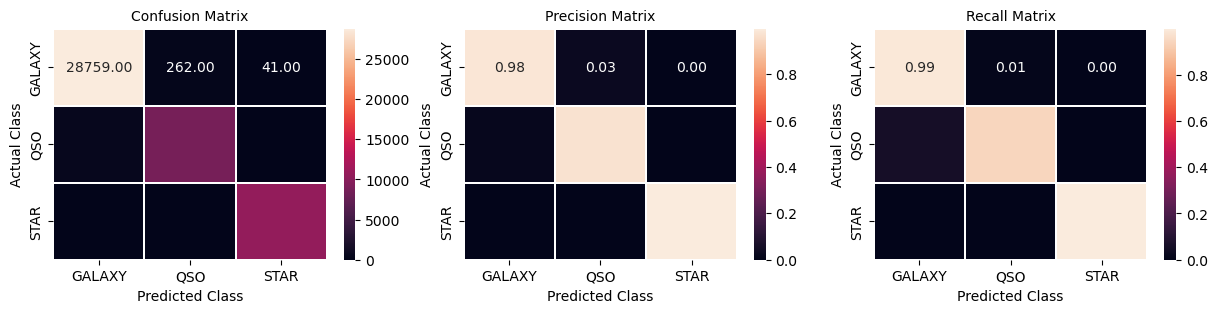

              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.99     29062
         QSO       0.97      0.94      0.96      9288
        STAR       1.00      1.00      1.00     10650

    accuracy                           0.98     49000
   macro avg       0.98      0.98      0.98     49000
weighted avg       0.98      0.98      0.98     49000

---------------------------------------------------------------------------------
VALID
Accuracy:  0.9761
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


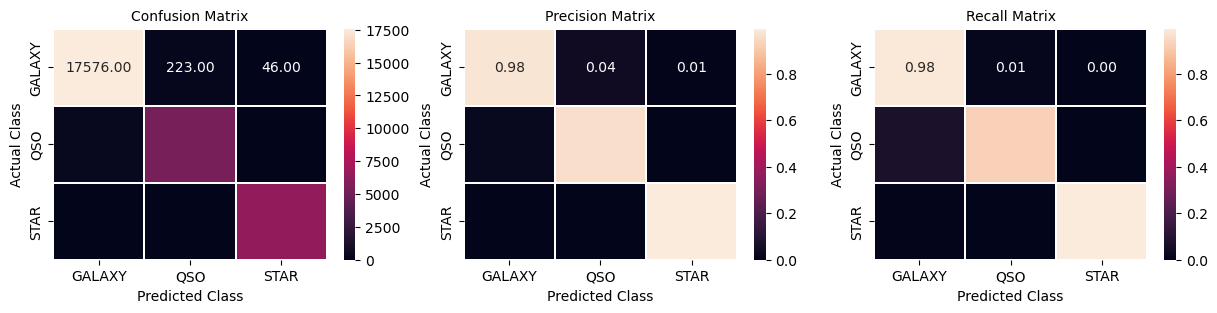

              precision    recall  f1-score   support

      GALAXY       0.98      0.98      0.98     17845
         QSO       0.96      0.93      0.94      5700
        STAR       0.99      0.99      0.99      6455

    accuracy                           0.98     30000
   macro avg       0.98      0.97      0.97     30000
weighted avg       0.98      0.98      0.98     30000

---------------------------------------------------------------------------------
Cross-validation scores:  [0.97663265 0.97316327 0.97561224 0.97336735 0.97459184]
Mean CV score:  0.9746734693877551
---------------------------------------------------------------------------------
Cross-validation scores for validation data:  [0.97183333 0.974      0.97233333 0.97783333 0.97583333]
Mean CV score for validation data:  0.9743666666666666
---------------------------------------------------------------------------------
ROC curve and AUC for each class


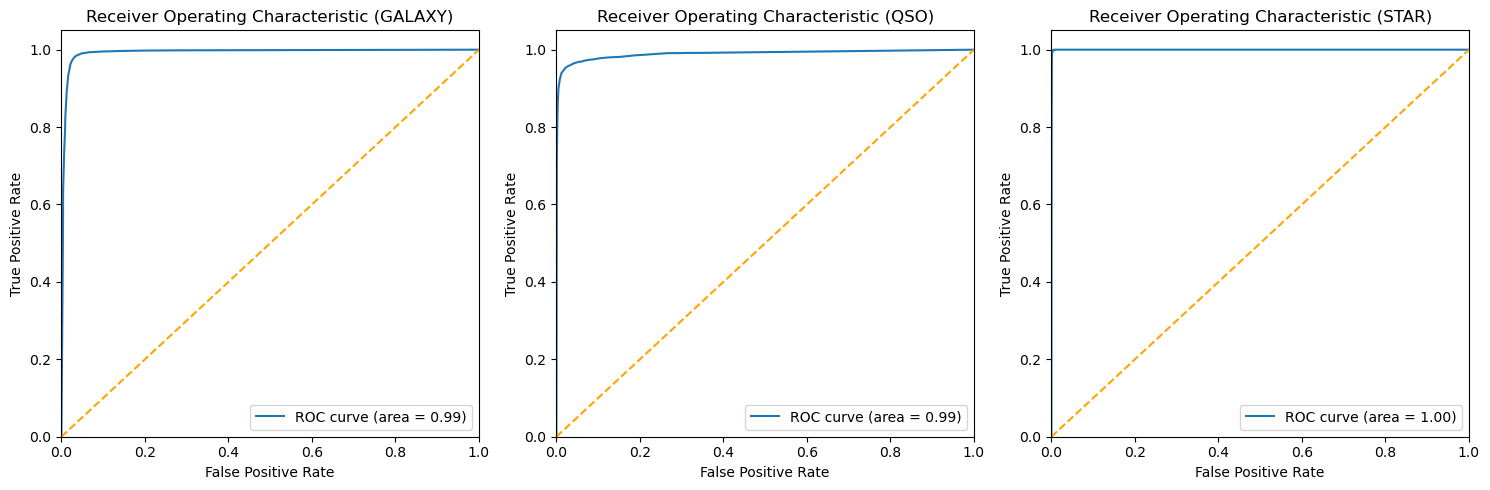

In [63]:
# Define your models
LR = LogisticRegression(penalty=lg_best_params['penalty'],
                        C=lg_best_params['C'],
                        class_weight='balanced',
                        random_state=42,
                        n_jobs=-1, max_iter=1000)

SV = SVC(C=svc_best_params['C'], random_state=42, class_weight='balanced')

KNN = KNeighborsClassifier(n_neighbors=knn_best_params['n_neighbors'], n_jobs=-1)

DT = DecisionTreeClassifier(criterion=dt_best_params['criterion'],
                            max_depth=dt_best_params['max_depth'],
                            min_samples_split=dt_best_params['min_samples_split'],
                            random_state=42)

models = [('LR', LR), ('SVC', SV), ('KNN', KNN), ('DT', DT)]

# Create StackingClassifier
stack = StackingClassifier(estimators=models, final_estimator=RandomForestClassifier(random_state=42))

# Fit StackingClassifier
stack.fit(X, y)

# Predictions
train_preds = stack.predict(X)
# test_preds = stack.predict(X_test)
valid_preds = stack.predict(X_valid)


# Calculate accuracy
stack_train_accuracy = accuracy_score(y, train_preds)
# stack_test_accuracy = accuracy_score(y_test, test_preds)
stack_valid_accuracy = accuracy_score(y_valid, valid_preds)


# Cross-validation
stack_cv_scores = cross_val_score(stack, X, y, cv=5)
# stack_cv_test_scores = cross_val_score(stack, X_test, y_test, cv=5)
stack_cv_valid_scores = cross_val_score(stack, X_valid, y_valid, cv=5)


# Print results
print("TRAIN")
print("Accuracy: ", stack_train_accuracy)
plot_confusion_matrix(y, train_preds, labels=['GALAXY', 'QSO', 'STAR'])
print(classification_report(y, train_preds, target_names=['GALAXY', 'QSO', 'STAR']))
print("---------------------------------------------------------------------------------")

# print("TEST")
# print("Accuracy: ", stack_test_accuracy)
# plot_confusion_matrix(y_test, test_preds, labels=['GALAXY', 'QSO', 'STAR'])
# print(classification_report(y_test, test_preds, target_names=['GALAXY', 'QSO', 'STAR']))
# print("---------------------------------------------------------------------------------")

print("VALID")
print("Accuracy: ", stack_valid_accuracy)
plot_confusion_matrix(y_valid, valid_preds, labels=['GALAXY', 'QSO', 'STAR'])
print(classification_report(y_valid, valid_preds, target_names=['GALAXY', 'QSO', 'STAR']))
print("---------------------------------------------------------------------------------")

print("Cross-validation scores: ", stack_cv_scores)
print("Mean CV score: ", np.mean(stack_cv_scores))
print("---------------------------------------------------------------------------------")
# print("Cross-validation scores for test data: ", stack_cv_test_scores)
# print("Mean CV score for test data: ", np.mean(stack_cv_test_scores))
print("Cross-validation scores for validation data: ", stack_cv_valid_scores)
print("Mean CV score for validation data: ", np.mean(stack_cv_valid_scores))

# Plot ROC curve for each class and calculate AUC
print("---------------------------------------------------------------------------------")
print("ROC curve and AUC for each class")
_, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axs):
    # y_true_binary = (y_test == label_encoder.classes_[i]).astype(int)
    # y_prob = stack.predict_proba(X_test)[:, i]  # predict_proba
    y_true_binary = (y_valid == label_encoder.classes_[i]).astype(int)
    y_prob = stack.predict_proba(X_valid)[:, i]  # predict_proba
    plot_roc_curve(y_true_binary, y_prob, class_label=label_encoder.classes_[i], ax=ax)
    
plt.tight_layout()
plt.show()

*Wnioski:*
* *Wyniki dla wskaźników accuracy, f1-score oraz recall są na wysokim poziomie zarówno dla danych treningowych, jak i walidacyjnych.*
* *Wskaźniki cross-validation score są na wysokim poziomie zarówno danych treningowych i walidacyjnych (ponad 0.9).*
* *Wskaźniki ROC-AUC zbliżone do 1.*

## 5. Wybrany model
Podsumujmy proces modelowania i wybierzmy najlepszy model dla naszego problemu.

+---+---------------------+----------------+---------------------+---------------+-----------------------------------+
|   |        Model        | Train Accuracy | Validation Accuracy | CV Mean Score | CV Mean Score for Validation Data |
+---+---------------------+----------------+---------------------+---------------+-----------------------------------+
| 1 |    Random Forest    |     0.9988     |       0.9778        |     0.978     |               0.977               |
| 7 |       XGBoost       |     0.9981     |       0.9777        |    0.9778     |              0.9778               |
| 8 |      Stacking       |     0.9825     |       0.9761        |    0.9747     |              0.9744               |
| 6 |         SVC         |     0.9736     |       0.9728        |    0.9719     |              0.9631               |
| 4 |    Decision Tree    |     0.9821     |       0.9722        |    0.9723     |              0.9712               |
| 3 | K-Nearest Neighbors |     0.9652     |    

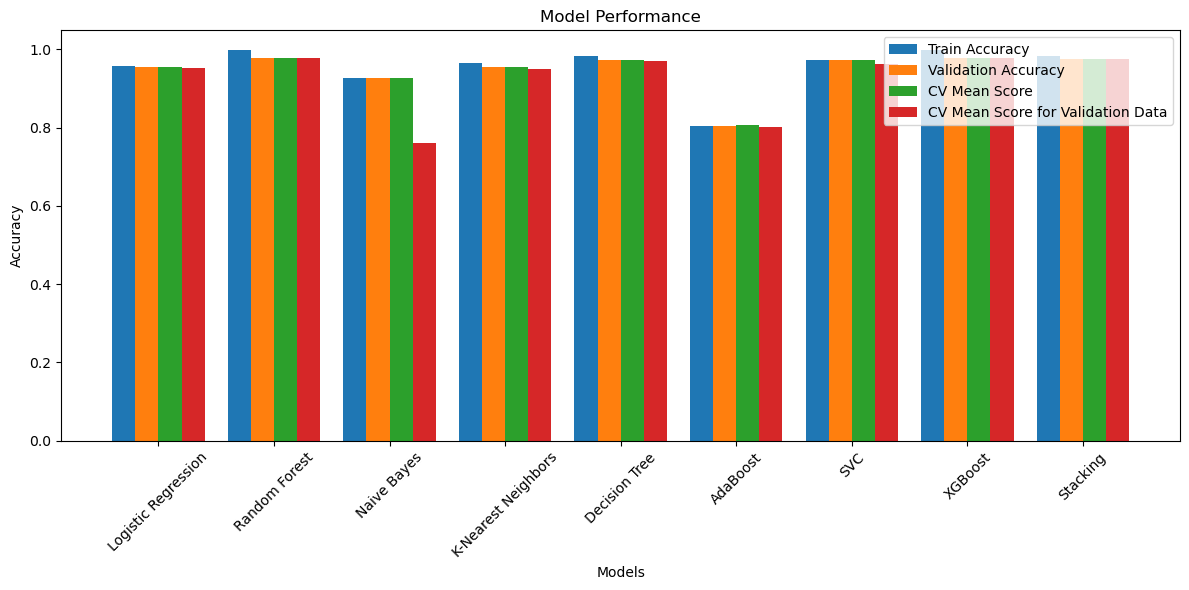

In [79]:
model_names = ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'K-Nearest Neighbors', 'Decision Tree', 'AdaBoost', 'SVC', 'XGBoost', 'Stacking']


train_accuracy = [lg_train_accuracy, rf_train_accuracy, nb_train_accuracy, knn_train_accuracy, dt_train_accuracy, ab_train_accuracy, svc_train_accuracy, xgb_train_accuracy, stack_train_accuracy]
# test_accuracy = [lg_test_accuracy, rf_test_accuracy, nb_test_accuracy, knn_test_accuracy, dt_test_accuracy, ab_test_accuracy, svc_test_accuracy, xgb_test_accuracy, stack_test_accuracy]
valid_accuracy = [lg_valid_accuracy, rf_valid_accuracy, nb_valid_accuracy, knn_valid_accuracy, dt_valid_accuracy, ab_valid_accuracy, svc_valid_accuracy, xgb_valid_accuracy, stack_valid_accuracy]
# average of cv scores
cv_scores = [np.mean(lg_cv_scores), np.mean(rf_cv_scores), np.mean(nb_cv_scores), np.mean(knn_cv_scores), np.mean(dt_cv_scores), np.mean(ab_cv_scores), np.mean(svc_cv_scores), np.mean(xgb_cv_scores), np.mean(stack_cv_scores)]
# cv_test_scores = [np.mean(lg_cv_test_scores), np.mean(rf_cv_test_scores), np.mean(nb_cv_test_scores), np.mean(knn_cv_test_scores), np.mean(dt_cv_test_scores), np.mean(ab_cv_test_scores), np.mean(svc_cv_test_scores), np.mean(xgb_cv_test_scores), np.mean(stack_cv_test_scores)]
cv_valid_scores = [np.mean(lg_cv_valid_scores), np.mean(rf_cv_valid_scores), np.mean(nb_cv_valid_scores), np.mean(knn_cv_valid_scores), np.mean(dt_cv_valid_scores), np.mean(ab_cv_valid_scores), np.mean(svc_cv_valid_scores), np.mean(xgb_cv_valid_scores), np.mean(stack_cv_valid_scores)]

results = pd.DataFrame({'Model': model_names, 'Train Accuracy': train_accuracy, 'Validation Accuracy': valid_accuracy, 'CV Mean Score': cv_scores, 'CV Mean Score for Validation Data': cv_valid_scores})

# round all accuracies to 4 decimal places
results = results.round(4)

# results order by test accuracy
results = results.sort_values(by='Validation Accuracy', ascending=False)
results = tabulate(results, headers='keys', tablefmt='pretty', showindex=True)
print(results)
# visualize
plt.figure(figsize=(12, 6))

# Set the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
index = np.arange(len(model_names))

# Plot bars for train accuracy
plt.bar(index - 1.5*bar_width, train_accuracy, bar_width, label='Train Accuracy')
# # Plot bars for test accuracy
# plt.bar(index - 0.5*bar_width, test_accuracy, bar_width, label='Test Accuracy')
# Plot bars for validation accuracy
plt.bar(index - 0.5*bar_width, valid_accuracy, bar_width, label='Validation Accuracy')
# Plot bars for CV mean score
plt.bar(index + 0.5*bar_width, cv_scores, bar_width, label='CV Mean Score')
# # Plot bars for CV mean score for test data
# plt.bar(index + 1.5*bar_width, cv_test_scores, bar_width, label='CV Mean Score for Test Data')
# Plot bars for CV mean score for validation data
plt.bar(index + 1.5*bar_width, cv_valid_scores, bar_width, label='CV Mean Score for Validation Data')

# Add x-axis labels
plt.xlabel('Models')
# Add y-axis label
plt.ylabel('Accuracy')
# Add title
plt.title('Model Performance')
# Add x-axis ticks and rotate labels for better readability
plt.xticks(index, model_names, rotation=45)
# Add legend
plt.legend()
# Show plot
plt.tight_layout()
plt.show()


*Przedstawienie porównania modeli wykonane zostało w sposób jasny i czytelny, chociaż patrząc po samym wykresie nieoczywistym będzie wybór najlepszego modelu, jako że wyniki ich działania są zbliżone. Legenda nachodzi na wykres. Brakuje też wniosków i podsumowania, który model został wybrany przez zespół budowy.*

## 6. AUTO ML

In [81]:
# %pip install tpot


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/87.4 kB ? eta -:--:--
   ---------------------------- ----------- 61.4/87.4 kB 1.1 MB/s eta 0:00:01
   ---------------------------------------- 87.4/87.4 kB 821.4 kB/s eta 0:00:00
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.6 MB 262.6 kB/s eta 0:00:41
   ---------------------------------------- 0.1/10.6 MB 819.2 kB/s eta 0:00:13
    --------------------------------------- 0.2/10.6 MB 1.3 MB/s eta 0:00:09
   - -------------------------------------- 0.4/10.6 MB 1.8 MB/s eta 0:00:06
   -- ------------------------------------- 0.6/10.6 MB 2.1 MB/s eta 0:00:05
   -- ------------------------------------- 0.8/10.6 MB 2.3 MB/s eta 0:00:05
   -- ------------------------------------- 0.8/10.6 MB 2.2 MB/

In [8]:
from tpot import TPOTClassifier
tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2, random_state=42)
tpot.fit(X, y)

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9721020408163266

Generation 2 - Current best internal CV score: 0.9748775510204082

Generation 3 - Current best internal CV score: 0.9751836734693876

Generation 4 - Current best internal CV score: 0.9751836734693876

Generation 5 - Current best internal CV score: 0.9752448979591837

Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.9000000000000001, min_samples_leaf=2, min_samples_split=13, n_estimators=100)


TPOTClassifier(generations=5, population_size=20, random_state=42, verbosity=2)

*Tutaj też by się przydało słowo komentarza.*

Wnioski:


*Brak wniosków i podsumowania projektu, coś by się przydało napisać:)*